# BangleBeat

---
Author: Lucas Miller
---


## Abstract(ish)

The following notebook walks through the process of making various simple, embeddable, models from scratch in an attempt to improve percieved heart rate from the [Bangle JS 2](https://shop.espruino.com/banglejs2) open source smart watch. The inputs to this notebook are described in the `README.md`, in short one needs a Gadgetbridge SQLite database full of intersecting data and a Bangle JS 2 watch to repeat this work. This should serve as a proof of concept and potentially a platform to improve heart rate correction in future work with larger data sets. Mean Absolute Error (MAE) is reduced to an attractive level (~10bpm -> ~2bpm), however maximum corrections are too large to be considered accurate in daily use. Ultimately future work should significantly expand the datasets captured while the user wears multiple devices simultaneously (herein referred to as "intersecting" datasets) to improve accuracy. Eventually this could lead to broader, open, health profile characterization which could generalize this approach. The best direct continuation, though, is deploying this pipeline as a BangleApps web UI to optimize the deployment pipeline, which may be found on my [BangleApps](https://github.com/lucspec/BangleApps) fork in the coming weeks.

## Data Capture Overview

First, we should assess how good or bad the BangleJS2 performs when compared to other wearable devices. This includes the following devices:

- BangleJS2 Smart Watch
- Garmin Instinct 2X Smart Watch
- Polar H10 ECG Chest Strap

These are all supported to a sufficient degree by [Gadgetbridge](https://gadgetbridge.org/). However, in the initial phases of this project I found that the BangleJS2 does not sample heart rate data nearly as fast as the Garmin does. To give this model a fighting chance I wrote [loglog](https://github.com/lucspec/BangleApps/tree/master/apps/loglog) -- a BangleJS2 app to prioritize data collection over battery life. The goal being to fuse accelerometer data with heart rate measurements to change sampling paradigms with activity. This proved to be too ambitious for a solo project over a few weeks, and I abandonded it in favor of the Heart Rate Recorder app for supplemental CSV data.

![Component Diagram](./assets/component-diagram.svg)

## Requirements

Before we properly get started, run the following section to ensure that your environment is set up properly.

In [ ]:
import sys
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import glob
import os

# ML Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

import sys
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
import tempfile
import os

import random
import matplotlib.pyplot as plt
import numpy as np

from sklearn.inspection import permutation_importance

import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from tensorflow.keras import models

import json


# Plotting Style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

print("Environment Ready")

Environment Ready


## Data Ingestion

With our sensors and collection mechanisms in place, we can start looking at some data. 

Steps to repeat are as follows:

1. Establish a data collection pipeline (possibly the one above)
2. Collect >100k samples per device (ideally intersecting - i.e. while multiple devices were worn simultaneously)
3. Create the `./data` directory and paste your `Gadgetbridge.db` files there

With these steps complete, you *should* be able to proceed with the notebook. **Your tables may look different from mine!**  Tools like `sqlitebrowser` (included in the nix flake) may be very helpful in determining which data tables might have the right heart rate data for this task. 

In [304]:
import sqlite3

conn = sqlite3.connect('./data/Gadgetbridge.db')

# Tables that likely have HR data
hr_tables = [
    'BANGLE_JSACTIVITY_SAMPLE',
    'GARMIN_ACTIVITY_SAMPLE',
    'GARMIN_HEART_RATE_RESTING_SAMPLE',
    'GARMIN_FIT_FILE',
    'POLAR_H10_ACTIVITY_SAMPLE'
]
for table in hr_tables:
    print("\n" + "="*80)
    print(f"TABLE: {table}")
    print("="*80)
    
    cursor = conn.cursor()
    
    # Get schema
    cursor.execute(f"PRAGMA table_info({table});")
    columns = cursor.fetchall()
    col_names = [col[1] for col in columns]
    
    print("\nColumns:")
    for col in columns:
        col_id, col_name, col_type, not_null, default, pk = col
        print(f"  {col_name:30s} {col_type:15s}")
    
    # Get count
    cursor.execute(f"SELECT COUNT(*) FROM {table};")
    count = cursor.fetchone()[0]
    
    # Show sample rows with headers
    if count > 0:
        cursor.execute(f"SELECT * FROM {table} LIMIT 3;")
        samples = cursor.fetchall()
        
        print("\nSample rows (of {count:,} total rows)\n")
        print("  " + " | ".join(f"{col:14s}" for col in col_names))
        print("  " + "-" * (len(col_names) * 16))
        for row in samples:
            print("  " + " | ".join(f"{str(val):14s}" for val in row))

conn.close()


TABLE: BANGLE_JSACTIVITY_SAMPLE

Columns:
  TIMESTAMP                      INTEGER        
  DEVICE_ID                      INTEGER        
  USER_ID                        INTEGER        
  RAW_INTENSITY                  INTEGER        
  STEPS                          INTEGER        
  RAW_KIND                       INTEGER        
  HEART_RATE                     INTEGER        

Sample rows (of {count:,} total rows)

  TIMESTAMP      | DEVICE_ID      | USER_ID        | RAW_INTENSITY  | STEPS          | RAW_KIND       | HEART_RATE    
  ----------------------------------------------------------------------------------------------------------------
  1763191201     | 5              | 1              | 216            | 0              | 8              | 76            
  1763238600     | 5              | 1              | 288            | 0              | 0              | 78            
  1763239200     | 5              | 1              | 256            | 0              | 0              

In this case, the Bangle JS and Polar H10 tables were easy (1 possible table) whereas the Garmin was complicated (15 possible tables). It took a litte work, but we narrowed down the data that we need from the Gadgetbridge database! Now let's load that data into a Pandas dataframe so we can interact with easily in the future.

In [ ]:
DB_SEARCH_PATHS = [ 
    "./data/Gadgetbridge*.db",
    "./data/Gadgetbridge*/database/Gadgetbridge",
]
CSV_SEARCH_PATHS = [
    "./data/loglog*.csv",
    "./data/HeartRateRecord*.csv",
]

# =============================================================================
# FUNCTION: LOAD DATABASE DATA
# =============================================================================
def load_db_data(db_pattern):
    dataframes = []
    dbs = glob.glob(db_pattern)
    
    # Mapping table names to timestamp units based on Gadgetbridge schema
    # Most ACTIVITY tables are seconds, EVENT/SAMPLE tables often ms
    table_configs = {
        'GARMIN_ACTIVITY_SAMPLE': {'unit': 's'},
        'BANGLE_JSACTIVITY_SAMPLE': {'unit': 's'},
        'POLAR_H10_ACTIVITY_SAMPLE': {'unit': 's'},
        # Add others if needed
    }

    type_to_table = {
        'GARMIN_INSTINCT_2X_SOLAR': 'GARMIN_ACTIVITY_SAMPLE',
        'BANGLEJS': 'BANGLE_JSACTIVITY_SAMPLE',
        'POLAR': 'POLAR_H10_ACTIVITY_SAMPLE',
    }

    for db_path in dbs:
        try:
            conn = sqlite3.connect(db_path)
            
            # Get Devices
            devices = pd.read_sql_query("SELECT * FROM DEVICE", conn)
            
            for _, device in devices.iterrows():
                # Resolve table name
                d_type = device.get('TYPE_NAME', '')
                if not d_type: continue
                
                table = None
                if d_type in type_to_table:
                    table = type_to_table[d_type]
                elif 'GARMIN' in d_type:
                    table = 'GARMIN_ACTIVITY_SAMPLE'
                elif 'BANGLE' in d_type:
                    table = 'BANGLE_JSACTIVITY_SAMPLE'
                elif 'POLAR' in d_type:
                    table = 'POLAR_H10_ACTIVITY_SAMPLE'
                
                if not table: continue
                
                # Check if table exists
                check = conn.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table}'").fetchone()
                if not check: continue

                # Query Data
                query = f"SELECT TIMESTAMP, HEART_RATE FROM {table} WHERE DEVICE_ID = ? AND HEART_RATE > 0"
                df = pd.read_sql_query(query, conn, params=(device['_id'],))
                
                if not df.empty:
                    # Apply correct timestamp conversion
                    ts_unit = table_configs.get(table, {}).get('unit', 's')
                    df['datetime'] = pd.to_datetime(df['TIMESTAMP'], unit=ts_unit)
                    df['device_name'] = device['NAME']
                    df['device_type'] = d_type
                    df['source'] = 'DATABASE'
                    dataframes.append(df)
            
            conn.close()
        except Exception as e:
            print(f"Error reading {db_path}: {e}")

    return pd.concat(dataframes, ignore_index=True) if dataframes else pd.DataFrame()

# =============================================================================
# FUNCTION: LOAD LOGLOG CSV DATA (HAS ACCELEROMETER)
# =============================================================================
def load_csv_data(csv_pattern):
    csvs = glob.glob(csv_pattern)
    dataframes = []
    
    for f in csvs:
        try:
            # Latin-1 often helps with the 'µ' symbol in units
            df = pd.read_csv(f, encoding='latin-1') 
            df.columns = df.columns.str.strip()
            
            # Rename for consistency
            rename_map = {
                'Epoch (ms)': 'TIMESTAMP',
                'BPM': 'HEART_RATE',
                'Confidence':'HRM_CONFIDENCE',
                # 'X': 'x', 'Y': 'y', 'Z': 'z', 'Total': 'total_accel'
            }
            df = df.rename(columns=rename_map)
            
            # Filter valid HR
            df = df[ (df['HEART_RATE'].notna()) & (df['HEART_RATE'] > 0) ]
            
            # Convert Timestamps (Loglog uses MS)
            df['datetime'] = pd.to_datetime(df['TIMESTAMP'], unit='ms')
            df['device_name'] = 'BangleJS-CSV'
            df['device_type'] = 'BANGLEJS'
            df['source'] = 'CSV'
            
            # # Ensure accel columns exist
            # for col in ['x', 'y', 'z']:
            #     if col not in df.columns:
            #         df[col] = np.nan
            
            dataframes.append(df)
        except Exception as e:
            print(f"Skipping {f}: {e}")
            
    return pd.concat(dataframes, ignore_index=True) if dataframes else pd.DataFrame()

# =============================================================================
# EXECUTE LOAD
# =============================================================================
dbs = []

for gadgetbridge_file in DB_SEARCH_PATHS:
    df_db = load_db_data(gadgetbridge_file)
    print(f"Loaded {len(df_db):7.0f} rows from {len(glob.glob(gadgetbridge_file)):3.0f} files matching \'{gadgetbridge_file}\'")
    dbs.append(df_db)

for csv_file in CSV_SEARCH_PATHS:
    df_csv = load_csv_data(csv_file)
    print(f"Loaded {len(df_csv):7.0f} rows from {len(glob.glob(csv_file)):3.0f} files matching \'{csv_file}\'")
    dbs.append(df_csv)

# Combine
hr_data = pd.concat(dbs, ignore_index=True).sort_values('datetime')
print()
print(f"  Total Combined Data: {len(hr_data):7.0f} rows.")

## NOTE -- THIS MODIFIES hr_data INPLACE, REDUCING THE SIZE OF THE DATA SET
hr_data.drop_duplicates(subset=None, inplace=True)
print(f"After Drop Duplicates: {len(hr_data):7.0f} rows.")


Loaded 1737635 rows from  10 files matching './data/Gadgetbridge*.db'
Loaded  399056 rows from   2 files matching './data/Gadgetbridge*/database/Gadgetbridge'
Loaded   19769 rows from   6 files matching './data/loglog*.csv'
Loaded   75048 rows from   2 files matching './data/HeartRateRecord*.csv'

  Total Combined Data: 2231508 rows.
After Drop Duplicates:  407819 rows.


Now we know that everything in `hr_data` is a unique sample. Let's take a closer look at what data we have by `device_name`. It's important that we choose `device_name` here instead of `device_type`, because `device_name` *does* distinguish between collection methods whereas `device_type` does not.

Note (in the original data) that deduplication resulted in a 5x reduction in overall data size. If you have fewer than ~100k samples per device **stop here** and gather more data. Ideally there would be upwards of 500k samples per device that cover the user's full heart rate range.

In [306]:
def data_stats(data: pd.DataFrame):
    devs = data['device_name'].unique()
    print('      Device       |   Count   | Date First |  Date Last | HR Min | HRMax | HR Mean ')
    print('-------------------------------------------------------------------------------------')
    for device in data['device_name'].unique():
        device_data = data[data['device_name'] == device]
        count = len(device_data)
        device_type = device_data['device_type'].iloc[0]
        date_range = device_data['datetime']
        hr_range = device_data['HEART_RATE']
        
        print(f"{device:18s} | {count:9d} | {date_range.min().strftime('%Y-%m-%d')} | {date_range.max().strftime('%Y-%m-%d')} |   {hr_range.min():3.0f}  |  {hr_range.max():3.0f}  |   {hr_range.mean():3.1f}")
        
        ## Show accelerometer data if available
        #if 'x' in device_data.columns:
        #    accel_complete = device_data[['x', 'y', 'z']].notna().all(axis=1).sum()
        #    if accel_complete > 0:
        #        print(f"    Accelerometer: {accel_complete:,} samples")


# REMOVE BAD TIMESTAMPS (epoch 0, null, corrupted)
#MIN_REAL_TIMESTAMP = pd.Timestamp("2000-01-01")
MIN_REAL_TIMESTAMP = pd.Timestamp("2025-09-01")

print(f'hr_data raw length ------------------- {len(hr_data)}')
data_stats(hr_data)

hr_data = hr_data.dropna(subset=["datetime"])
print(f'\nhr_data length after dropna ---------- {len(hr_data)}')
#data_stats(hr_data)

hr_data = hr_data[hr_data["datetime"] >= MIN_REAL_TIMESTAMP]
print(f'\nhr_data length after timestamp trim -- {len(hr_data)}')
data_stats(hr_data)


hr_data raw length ------------------- 407819
      Device       |   Count   | Date First |  Date Last | HR Min | HRMax | HR Mean 
-------------------------------------------------------------------------------------
Bangle.js db9a     |     24520 | 1970-01-01 | 2025-11-28 |    49  |  184  |   80.4
BangleJS-CSV       |     94804 | 1970-01-21 | 2025-11-21 |     4  |  115  |   75.9
Instinct 2X Solar  |    166002 | 2025-06-08 | 2025-11-26 |    38  |  176  |   76.2
Polar H10 CC3A8829 |    122493 | 2025-11-09 | 2025-11-27 |    58  |  174  |   86.6

hr_data length after dropna ---------- 407819

hr_data length after timestamp trim -- 221607
      Device       |   Count   | Date First |  Date Last | HR Min | HRMax | HR Mean 
-------------------------------------------------------------------------------------
Instinct 2X Solar  |     76665 | 2025-09-01 | 2025-11-26 |    46  |  176  |   74.9
Bangle.js db9a     |      2691 | 2025-09-25 | 2025-11-28 |    49  |  176  |   81.3
Polar H10 CC3A8829 |

Now that we have passed the inital condiditioning stage it is vital that we find how much (dis)agreement there is between the Bangle JS and our reference device. After all, if our devices agree at the outset then we shouldn't waste our time trying to coerce them into agreeing!

First, an important note on timing. Since our devices don't have well synchronized clocks (base timestamp differences, reporting latency, etc) we can't say for certain if samples were simultaneous. An easy way to approximate this is to give an alignment tolerance. That is, how far apart samples from two devices can be and we still consider them to be simultaneous. It would take significant biological expertise to say exactly what this number should be. Instead we can choose some relatively small number for human beings and a relatively large number for embedded system timing like 5 seconds.

In [315]:
# =============================================================================
# STEP 2: ALIGNMENT & PREPARATION
# =============================================================================
ALIGNMENT_TOLERANCE = '5s'
MIN_SAMPLES=10 # to form a segment `ALIGNMENT_TOLERANCE` wide
TRAINING_FEATURES = ['HEART_RATE', 'x', 'y', 'z']

# 1. Make a reference df wherever GARMIN or POLAR overlap with the bangle
reference_df = hr_data[
    hr_data['device_type'].str.contains('POLAR|GARMIN', case=False, na=False)
].copy()
reference_df = reference_df.sort_values('datetime').dropna(subset=['HEART_RATE'])

bangle_df = hr_data[
    hr_data['device_type'].str.contains('BANGLEJS', case=False, na=False)
].copy()
bangle_df = bangle_df.sort_values('datetime')

print(f"Reference Samples: {len(reference_df):,}")
print(f"   Bangle Samples: {len(bangle_df):,}")


# 2. Detect and remove large gaps in reference data
MAX_GAP = pd.Timedelta(ALIGNMENT_TOLERANCE)

reference_df["delta"] = reference_df["datetime"].diff()
reference_df["segment"] = (reference_df["delta"] > MAX_GAP).cumsum()
reference_df = reference_df.drop(columns=["delta"])

valid_segments = []
for seg_id, seg_df in reference_df.groupby("segment"):
    if len(seg_df) < MIN_SAMPLES:
        continue
    valid_segments.append(seg_df)

reference_df = pd.concat(valid_segments, ignore_index=True).sort_values("datetime")
print(f"Reference segments after gap-removal: {reference_df['segment'].nunique()}")


# 3. Merge-asof only within valid segments
aligned_blocks = []
for seg_id, seg_ref in reference_df.groupby("segment"):
    seg_start = seg_ref["datetime"].min()
    seg_end   = seg_ref["datetime"].max()

    seg_bangle = bangle_df[
        (bangle_df["datetime"] >= seg_start) &
        (bangle_df["datetime"] <= seg_end)
    ]
    if seg_bangle.empty:
        continue

    merged = pd.merge_asof(
        seg_bangle.sort_values("datetime"),
        seg_ref[["datetime", "HEART_RATE"]].rename(columns={"HEART_RATE": "HRREF"}),
        on="datetime",
        direction="nearest",
        tolerance=pd.Timedelta(ALIGNMENT_TOLERANCE)
    )

    aligned_blocks.append(merged)

if len(aligned_blocks) == 0:
    raise RuntimeError("No aligned segments produced any matches!")

aligned_data = pd.concat(aligned_blocks, ignore_index=True)


# 4. Drop rows with no match
aligned_data = aligned_data.dropna(subset=["HRREF"])

print("\nAlignment Results:")
print(f"  Matched Rows: {len(aligned_data):,}")
print(f"  Match Rate: {len(aligned_data)/len(bangle_df):.1%}")


# 5. Final cleanup — accel + HR required
#aligned_data = aligned_data.dropna(subset=['x','y','z','HEART_RATE'])
print(f"  Rows valid for training: {len(aligned_data):,}")


Reference Samples: 199,158
   Bangle Samples: 22,449
Reference segments after gap-removal: 146

Alignment Results:
  Matched Rows: 2,118
  Match Rate: 9.4%
  Rows valid for training: 2,118


In [ ]:
# Heart rate range for normalization, semi-anonymized -- HR is a biometric
MIN_HR = 0 # Minimum heart rate for normalization
#MIN_HR = hr_data['HEART_RATE'].min() # force 0-1 to actual measurement range
MAX_HR = hr_data['HEART_RATE'].max()  

# =============================================================================
# NORMALIZE HEART RATE DATA IN DEDICATED COLUMN
# =============================================================================
if not hr_data.empty and 'HEART_RATE' in hr_data.columns:
    # Normalize to 0-1 scale
    hr_data['HR_NORMALIZED'] = (hr_data['HEART_RATE'] - MIN_HR) / (MAX_HR - MIN_HR)
    
    # Clip values to 0-1 range (in case of values outside min/max)
    #hr_data['HR_NORMALIZED'] = hr_data['HR_NORMALIZED'].clip(0, 1)
    
    print("="*80)
    print(f"✓ Added HR_NORMALIZED column")
    print("="*80)
    print(f"  Range: {hr_data['HR_NORMALIZED'].min():.3f} to {hr_data['HR_NORMALIZED'].max():.3f}")
    print(f"  Mean: {hr_data['HR_NORMALIZED'].mean():.3f}")
    
    # Show any clipped values
    clipped_low = (hr_data['HEART_RATE'] < MIN_HR).sum()
    clipped_high = (hr_data['HEART_RATE'] > MAX_HR).sum()
    if clipped_low > 0:
        print(f"  ⚠ Clipped {clipped_low} values below {MIN_HR} bpm to 0.0")
    if clipped_high > 0:
        print(f"  ⚠ Clipped {clipped_high} values above {MAX_HR} bpm to 1.0")

NORMALIZED = True


✓ Added HR_NORMALIZED column
  Range: 0.023 to 1.000
  Mean: 0.457


Now, let's take a look at some visualizations of the data we are working with. Raw distribution gives a good feel for how "big" of a data set we have for each device whereas normalized density shows how (dis)similar our sets are.

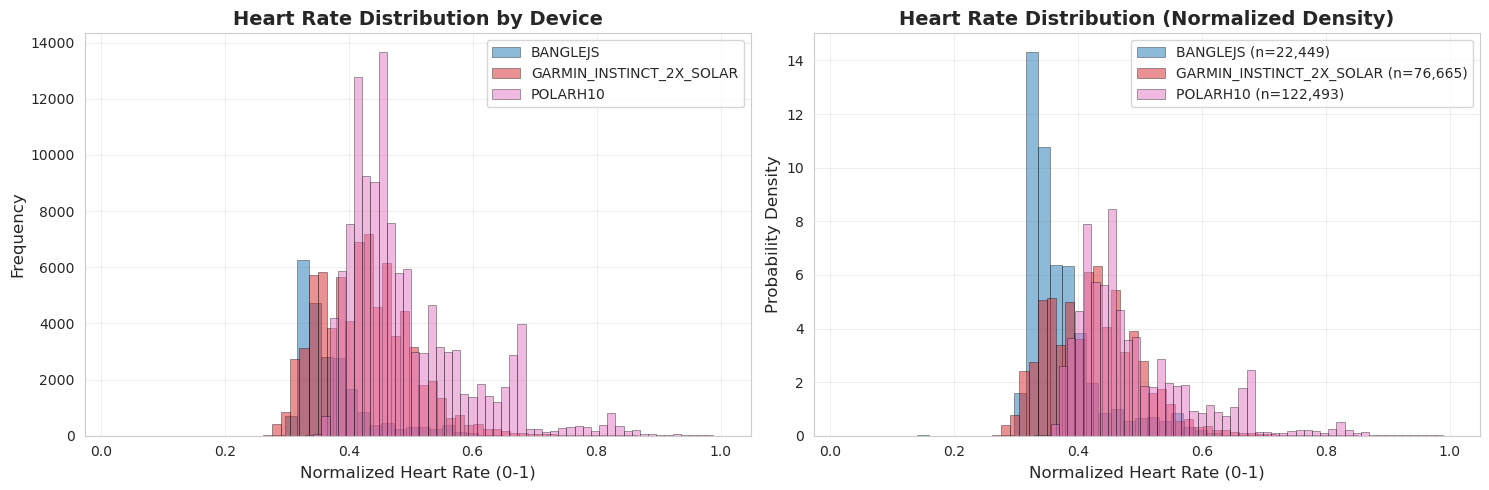

In [ ]:
BINS = 50
FIGSIZE = (15, 5)
DEV='device_type' # device_type (groups Bangle CSVs + GB) or device_name (all sources treated as unique)
CM=9

# =============================================================================
# PLOT HISTOGRAMS
# =============================================================================
if 'hr_data' not in locals() or hr_data.empty:
    print("Error: hr_data not found")
else:
    fig, axes = plt.subplots(1, 2, figsize=FIGSIZE)
    
    devices = sorted(hr_data['device_type'].unique())
    colors = plt.cm.tab10(np.linspace(0, CM, CM*len(devices)))
    
    # Select column
    hr_column = 'HR_NORMALIZED' if NORMALIZED and 'HR_NORMALIZED' in hr_data.columns else 'HEART_RATE'
    xlabel = 'Normalized Heart Rate (0-1)' if NORMALIZED else 'Heart Rate (bpm)'
    
    # Left: Individual histograms (stacked)
    for device, color in zip(devices, colors):
        device_data = hr_data[hr_data[DEV] == device][hr_column]
        axes[0].hist(device_data, bins=BINS, alpha=0.5, label=device, 
                    color=color, edgecolor='black', linewidth=0.5, histtype='bar')
    
    axes[0].set_title('Heart Rate Distribution by Device', fontsize=14, fontweight='bold')
    axes[0].set_xlabel(xlabel, fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Right: Density plots (normalized for comparison)
    for device, color in zip(devices, colors):
        device_data = hr_data[hr_data[DEV] == device][hr_column]
        n_samples = len(device_data)
        axes[1].hist(device_data, bins=BINS, alpha=0.5, 
                    label=f'{device} (n={n_samples:,})', 
                    color=color, edgecolor='black', linewidth=0.5,
                    density=True)
    
    axes[1].set_title('Heart Rate Distribution (Normalized Density)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel(xlabel, fontsize=12)
    axes[1].set_ylabel('Probability Density', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Now to visualize that pesky intersection. In an ideal set every vertical section of the following graph would have samples for all of our devices.

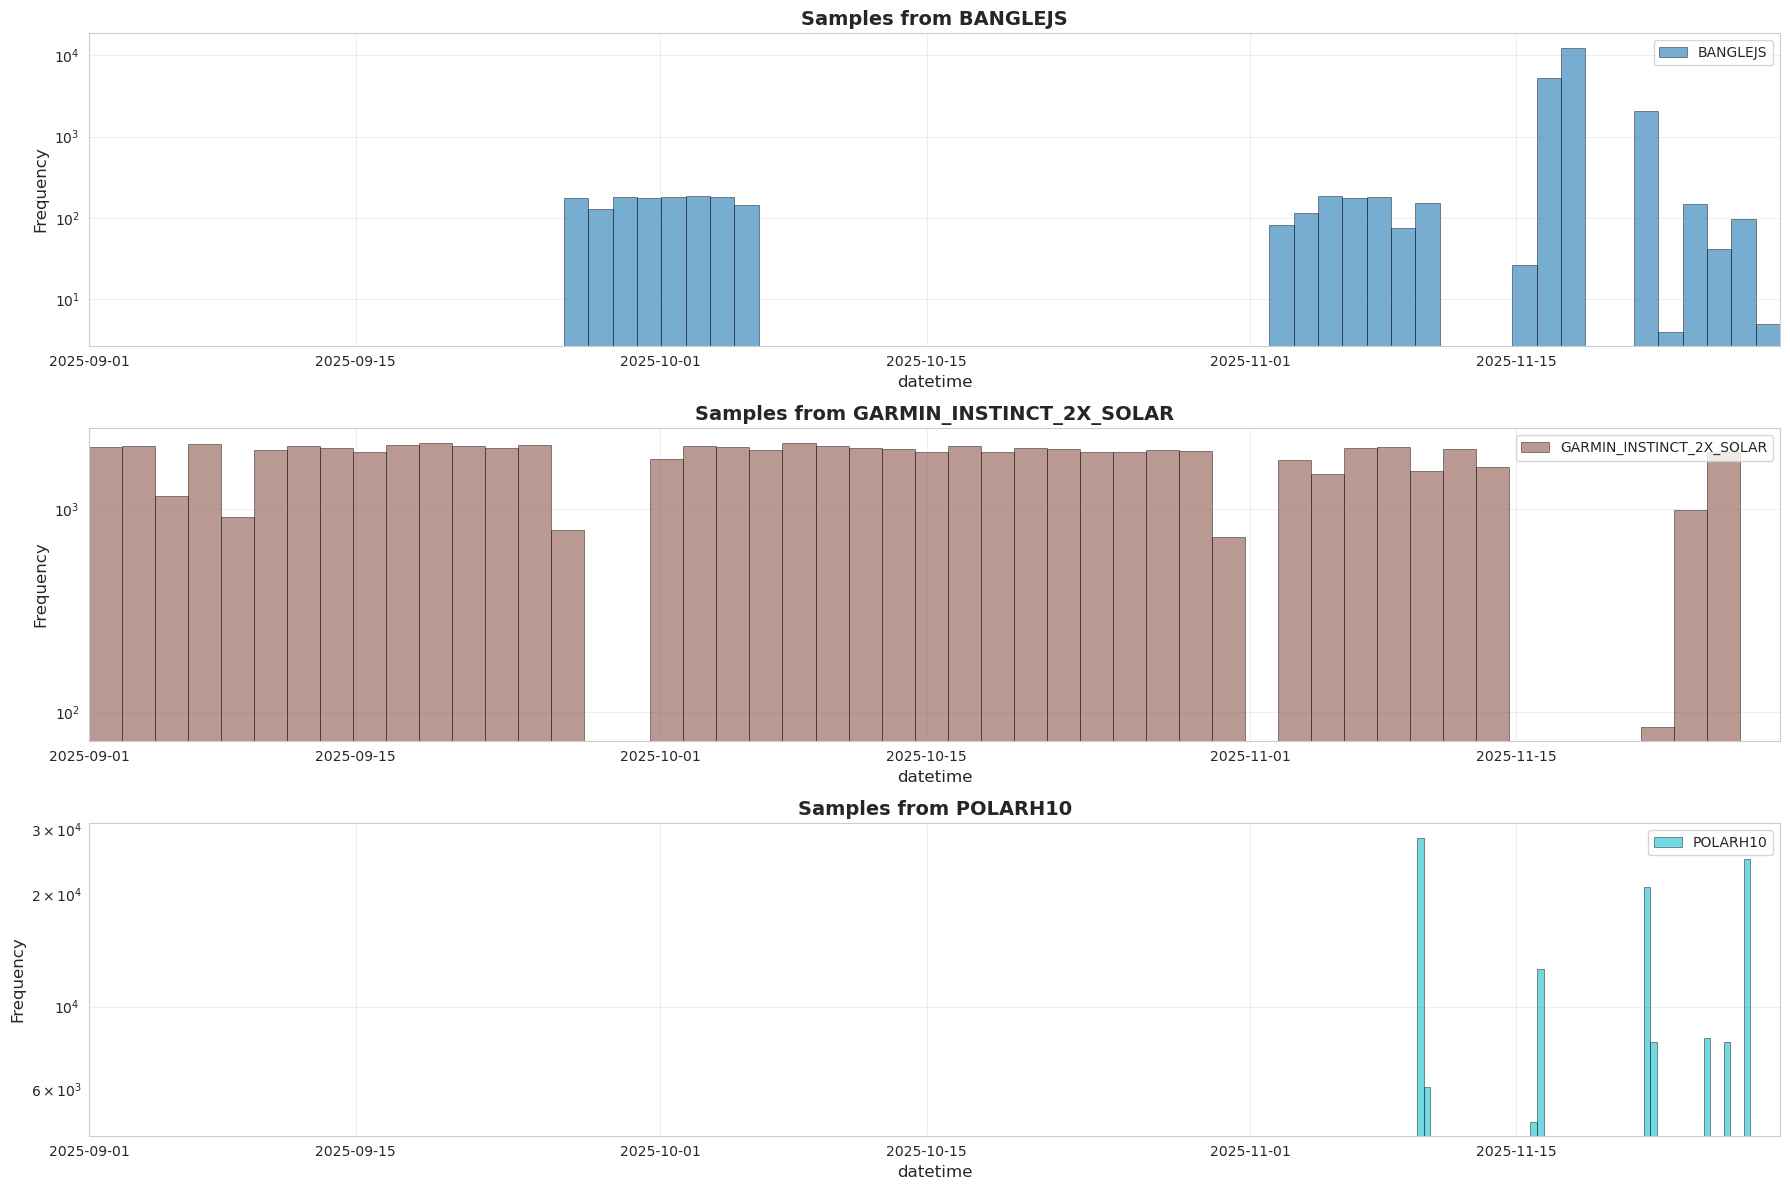

In [ ]:
BINS = 50
FIGSIZE = (18, 12)
DEV='device_type'

# =============================================================================
# PLOT HISTOGRAMS
# =============================================================================
if 'hr_data' not in locals() or hr_data.empty:
    print("Error: hr_data not found")
else:
    devices = sorted(hr_data[DEV].unique())
    ndevices = len(devices)
    colors = plt.cm.tab10(np.linspace(0, 1, ndevices))
    fig, axes = plt.subplots(ndevices, 1, figsize=FIGSIZE)
    
    # Select column
    dt_column = 'datetime'
    xlabel = 'datetime'
    xmin = hr_data['datetime'].min()    
    xmax = hr_data['datetime'].max()

    # Left: Individual histograms (stacked)
    for device, color, n in zip(devices, colors, range(0,ndevices)):
        device_data = hr_data[hr_data[DEV] == device][dt_column]
        axes[n].hist(device_data, bins=BINS, alpha=0.6, label=device, 
                    color=color, edgecolor='black', linewidth=0.5)
    
        axes[n].set_title(f'Samples from {device}', fontsize=14, fontweight='bold')
        axes[n].set_xlabel(xlabel, fontsize=12)
        axes[n].set_xlim([xmin,xmax])
        axes[n].set_ylabel('Frequency', fontsize=12)
        axes[n].set_yscale('log')
        axes[n].legend()
        axes[n].grid(True, alpha=0.3)
        
    plt.tight_layout()
    plt.show()

The data above in the original seems worse on first glance than it is. Garmin Instinct 2X data covers 90% of our timeline, while the Bangle and Polar cover significantly less. Based on the magnitutes of the samples this *should* be acceptable, though ideally I would significantly expand the intersecting data set.

The best way to fight data fear is with more data, so the next step is to see how well our measurements correlate.

CORRELATION ANALYSIS (vs Polar H10 CC3A8829)

Instinct 2X Solar:
  Paired samples: 707
  Correlation (R): 0.666
  R²: 0.443
  MAE: 0.04 bpm
  RMSE: 0.05 bpm
  Mean difference: -0.02 bpm

Bangle.js db9a:
  Paired samples: 165
  Correlation (R): 0.445
  R²: 0.198
  MAE: 0.07 bpm
  RMSE: 0.10 bpm
  Mean difference: -0.01 bpm

BangleJS-CSV:
  Paired samples: 1,957
  Correlation (R): 0.097
  R²: 0.009
  MAE: 0.04 bpm
  RMSE: 0.07 bpm
  Mean difference: 0.03 bpm


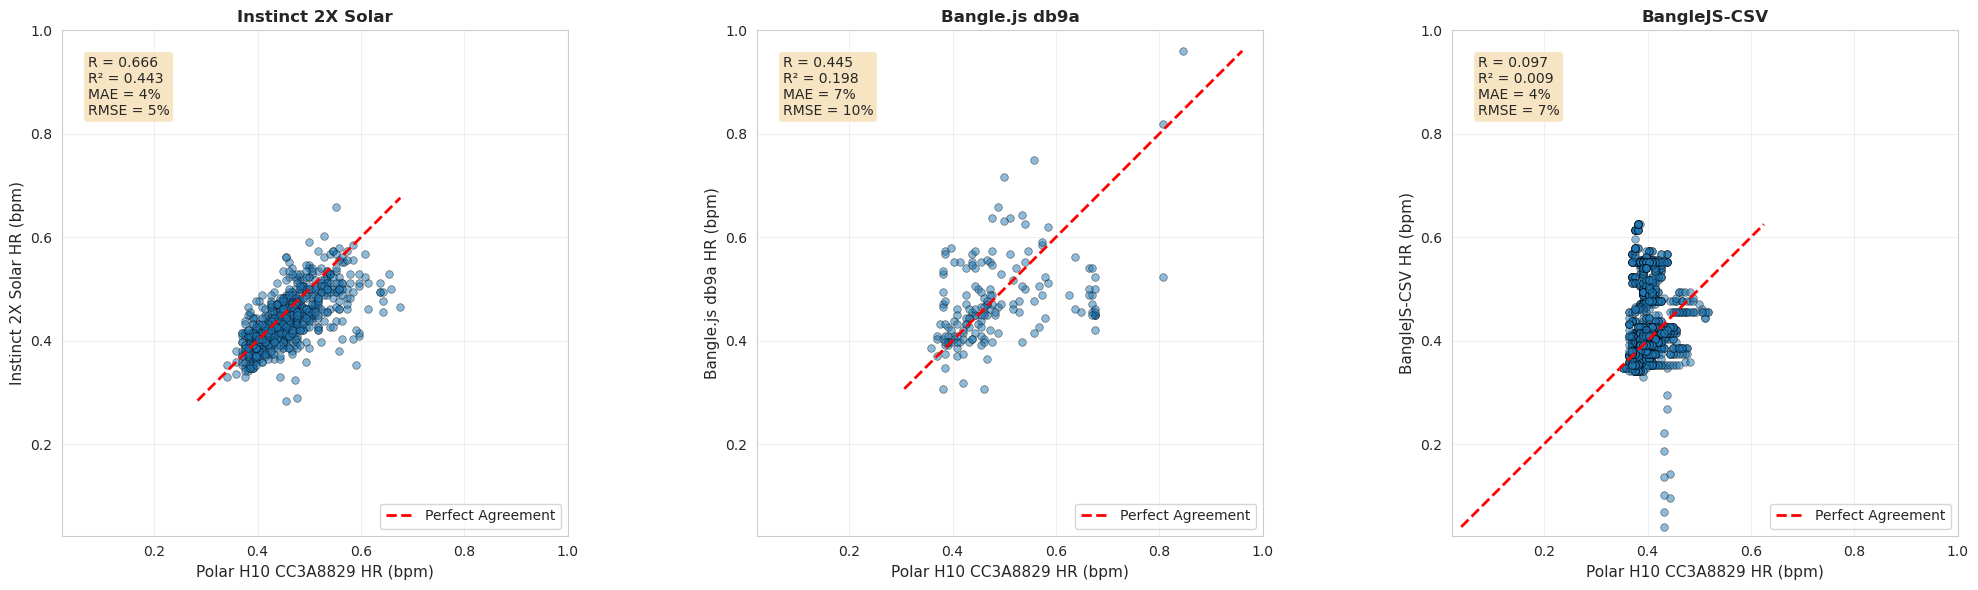

In [ ]:
REFERENCE_DEVICE = 'Polar H10 CC3A8829'  # Reference device (gold standard)
TOLERANCE_SECONDS = 60  # Max time difference for matching measurements
FIGSIZE_PER_DEVICE = 7
PLOT_RANGE = [hr_data['HR_NORMALIZED'].min(),hr_data['HR_NORMALIZED'].max()]

# =============================================================================
# CORRELATION ANALYSIS
# =============================================================================
if 'hr_data' not in locals() or hr_data.empty:
    print("Error: hr_data not found")
else:
    # Try to find reference device
    polar_data = hr_data[hr_data['device_name'] == REFERENCE_DEVICE]
    
    if polar_data.empty:
        polar_matches = hr_data[hr_data['device_name'].str.contains('Polar', case=False, na=False)]
        if not polar_matches.empty:
            REFERENCE_DEVICE = polar_matches['device_name'].iloc[0]
            polar_data = hr_data[hr_data['device_name'] == REFERENCE_DEVICE]
            print(f"Using reference device: {REFERENCE_DEVICE}")
    
    if polar_data.empty:
        print(f"Error: Reference device not found in data")
        print(f"Available devices: {list(hr_data['device_name'].unique())}")
    else:
        polar_data = polar_data[['datetime', 'HR_NORMALIZED']].copy()
        polar_data.columns = ['datetime', 'polar_hr']
        
        other_devices = [d for d in hr_data['device_name'].unique() if d != REFERENCE_DEVICE]
        
        if not other_devices:
            print("Error: Need at least one other device for comparison")
        else:
            n_devices = len(other_devices)
            fig, axes = plt.subplots(1, n_devices, figsize=(FIGSIZE_PER_DEVICE*n_devices, 6))
            
            if n_devices == 1:
                axes = [axes]
            
            print("="*80)
            print(f"CORRELATION ANALYSIS (vs {REFERENCE_DEVICE})")
            print("="*80)
            
            for idx, device in enumerate(other_devices):
                device_data = hr_data[hr_data['device_name'] == device][['datetime', 'HR_NORMALIZED']].copy()
                device_data.columns = ['datetime', 'device_hr']
                
                # Merge on nearest timestamps
                merged = pd.merge_asof(
                    device_data.sort_values('datetime'),
                    polar_data.sort_values('datetime'),
                    on='datetime',
                    direction='nearest',
                    tolerance=pd.Timedelta(f'{TOLERANCE_SECONDS}s')
                ).dropna()
                
                if not merged.empty:
                    axes[idx].scatter(merged['polar_hr'], merged['device_hr'], 
                                     alpha=0.5, s=30, edgecolors='black', linewidth=0.5)
                    
                    # Plot perfect agreement line
                    min_val = min(merged['polar_hr'].min(), merged['device_hr'].min())
                    max_val = max(merged['polar_hr'].max(), merged['device_hr'].max())
                    axes[idx].plot([min_val, max_val], [min_val, max_val], 
                                  'r--', linewidth=2, label='Perfect Agreement')
                    
                    # Calculate statistics
                    correlation = merged['polar_hr'].corr(merged['device_hr'])
                    mae = np.abs(merged['device_hr'] - merged['polar_hr']).mean()
                    rmse = np.sqrt(((merged['device_hr'] - merged['polar_hr']) ** 2).mean())
                    
                    # Display stats on plot
                    stats_text = f'R = {correlation:.3f}\nR² = {correlation**2:.3f}\nMAE = {100*mae:.0f}%\nRMSE = {100*rmse:.0f}%'
                    axes[idx].text(0.05, 0.95, stats_text,
                                  transform=axes[idx].transAxes, 
                                  verticalalignment='top',
                                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                                  fontsize=10)
                    
                    axes[idx].set_xlabel(f'{REFERENCE_DEVICE} HR (bpm)', fontsize=11)
                    axes[idx].set_ylabel(f'{device} HR (bpm)', fontsize=11)
                    axes[idx].set_xlim(PLOT_RANGE)
                    axes[idx].set_ylim(PLOT_RANGE)
                    axes[idx].set_title(f'{device}', fontsize=12, fontweight='bold')
                    axes[idx].legend(loc='lower right')
                    axes[idx].grid(True, alpha=0.3)
                    axes[idx].set_aspect('equal', adjustable='box')
                    
                    # Print statistics
                    print(f"\n{device}:")
                    print(f"  Paired samples: {len(merged):,}")
                    print(f"  Correlation (R): {correlation:.3f}")
                    print(f"  R²: {correlation**2:.3f}")
                    print(f"  MAE: {mae:.2f} bpm")
                    print(f"  RMSE: {rmse:.2f} bpm")
                    print(f"  Mean difference: {(merged['device_hr'] - merged['polar_hr']).mean():.2f} bpm")
                else:
                    axes[idx].text(0.5, 0.5, f'No overlapping data\nwith {REFERENCE_DEVICE}',
                                  ha='center', va='center', transform=axes[idx].transAxes,
                                  fontsize=12)
                    axes[idx].set_title(f'{device}', fontsize=12, fontweight='bold')
                    print(f"\n{device}: No overlapping data within {TOLERANCE_SECONDS}s")
            
            plt.tight_layout()
            plt.show()

As expected, Garmin and Polar agree very well. The Bangle data is oddly shaped and has a much larger standard deviation from the Polar than the Garmin device did. (Bad for the Bangle, but excellent for justifying the hunch that started this project).

## Model Making

Now that we have a basic understanding of our data and some noted disagreement, we have reached our first bump in the road that might make this difficult to follow. The next cell is a large set of funcitons that will be important later for creating our regression models and neural networks. This is set up as a set of functions so we can control our feature sets and simplify our procedures to follow. Treat this like an ipynb library. It is important to understand that it exists and generally what is happening, but in the end these are simply tools for later processes.

In [ ]:
ESTIMATORS = 80
DEPTH = 8

def get_model_size(model):
    """Calculate model size in bytes"""
    try:
        # For sklearn models, use pickle
        if hasattr(model, 'fit') and not isinstance(model, keras.Model):
            return len(pickle.dumps(model))
        # For Keras models, save to temp file and get size
        elif isinstance(model, keras.Model):
            with tempfile.NamedTemporaryFile(suffix='.keras', delete=False) as tmp:
                model.save(tmp.name)
                size = os.path.getsize(tmp.name)
                os.unlink(tmp.name)
                return size
    except Exception as e:
        print(f"Error calculating size: {e}")
        return None

def format_size(size_bytes):
    """Convert bytes to human-readable format"""
    if size_bytes is None:
        return "N/A"
    for unit in ['B', 'KB', 'MB']:
        if size_bytes < 1024.0:
            return f"{size_bytes:.2f} {unit}"
        size_bytes /= 1024.0
    return f"{size_bytes:.2f} GB"

def train_regression(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    baseline_mae = mean_absolute_error(y_test, X_test['HEART_RATE'])

    models = {
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=1.0),
        'ElasticNet': ElasticNet(alpha=1.0),
        'Random Forest': RandomForestRegressor(
            n_estimators=ESTIMATORS, max_depth=DEPTH, random_state=42
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=ESTIMATORS, max_depth=DEPTH//2, random_state=42
        ),
        'SVR': SVR(kernel='rbf', C=ESTIMATORS),
        'KNN': KNeighborsRegressor(n_neighbors=5),
        'Decision Tree': DecisionTreeRegressor(max_depth=DEPTH, random_state=42)
    }

    results = []

    print(f"Baseline (no correction): {baseline_mae:.2f} bpm\n")
    print("Model Comparison:")
    print("=" * 80)

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        improvement = baseline_mae - mae
        
        # Calculate model size
        size_bytes = get_model_size(model)
        size_kb = size_bytes/1000
        
        results.append({
            'Model': name,
            'MAE': mae,
            'R²': r2,
            'Improvement': improvement,
            'Size_Bytes': size_bytes,
            'Size_KB': size_kb,
            'model_obj': model  # Store the actual model
        })
        
        print(f"{name:20s} MAE: {mae:5.2f} bpm  R²: {r2:6.4f}  "
              f"Δ: {improvement:+5.2f} bpm  Size (KB): {size_kb}")

    results_df = pd.DataFrame(results).sort_values('MAE')
    print(f"\n>>> Best regression: {results_df.iloc[0]['Model']}")

    return results_df

def train_nns(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    baseline_mae = mean_absolute_error(
        y_test, aligned_data.loc[X_test.index, 'HEART_RATE']
    )
    print("\n" + "=" * 80)
    print(f"Training Neural Nets -- Baseline MAE: {baseline_mae:.2f} bpm")

    def create_nn(input_dim, layers_config=[64, 32, 16], dropout=0.2):
        model = keras.Sequential()
        model.add(layers.Input(shape=(input_dim,)))
        
        for units in layers_config:
            model.add(layers.Dense(units, activation='relu'))
            model.add(layers.Dropout(dropout))
        
        model.add(layers.Dense(1, activation='linear'))
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model

    architectures = {
        'Small-nn': [32, 16],
        'Mid-nn': [64, 32, 16],
        'Big-nn': [128, 64, 32],
        'Deep-nn': [64, 64, 32, 32]
    }

    results = []
    
    for name, layers_config in architectures.items():
        print()
        
        model = create_nn(X_train_scaled.shape[1], layers_config)
        
        early_stop = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=20, restore_best_weights=True
        )
        
        history = model.fit(
            X_train_scaled, y_train,
            validation_split=0.2,
            epochs=200,
            batch_size=32,
            callbacks=[early_stop],
            verbose=0
        )
        
        y_pred = model.predict(X_test_scaled, verbose=0).flatten()
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Calculate model size
        size_bytes = get_model_size(model)
        size_kb = size_bytes / 1000
        
        results.append({
            'Architecture': name,
            'Layers': str(layers_config),
            'MAE': mae,
            'R²': r2,
            'Size_Bytes': size_bytes,
            'Size_KB': size_kb,
            'Model': model,
            'Scaler': scaler  # Store scaler for NN predictions
        })
        
        print(f"Arch {layers_config} - MAE: {mae:.2f} bpm  "
              f"R²: {r2:.4f}  Size: {size_kb}")

    models_df = pd.DataFrame(results).sort_values('MAE')
    print(f"\n>>> Best NN: {models_df.iloc[0]['Architecture']:20s} - "
          f"MAE: {models_df.iloc[0]['MAE']:.2f} bpm")

    return models_df

def train_models(X, y):
    """Train all models and return combined dataframe"""
    X, y = X.align(y, join='inner', axis=0)
    
    # Train both model types
    regression_df = train_regression(X, y)
    nn_df = train_nns(X, y)
    
    # Rename columns for consistency
    nn_df = nn_df.rename(columns={'Architecture': 'Model', 'Model': 'model_obj'})
    
    # Combine results
    combined_df = pd.concat([regression_df, nn_df], ignore_index=True)
    
    return combined_df

# ============================================================================
# USAGE EXAMPLES
# ============================================================================

# Train models
# models_df = train_models(X, y)

# Filter by MAE threshold
# good_models = models_df[models_df['MAE'] < 5.0]

# Filter by size (e.g., under 1MB)
# small_models = models_df[models_df['Size_Bytes'] < 1_000_000]

# Get best model by MAE that's under a certain size
# efficient_models = models_df[models_df['Size_Bytes'] < 500_000].sort_values('MAE')
# best_efficient = efficient_models.iloc[0]

# Make predictions with a filtered model
# selected_model = models_df[models_df['MAE'] < 4.0].iloc[0]['model_obj']
# predictions = selected_model.predict(X_new)

# For neural networks, use the scaler too:
# nn_row = models_df[models_df['Model'] == 'Mid-nn'].iloc[0]
# nn_model = nn_row['model_obj']
# scaler = nn_row['Scaler']
# X_scaled = scaler.transform(X_new)
# predictions = nn_model.predict(X_scaled)

With the groundwork laid, we should start be creating distinct sets for the device we are attempting to improve (the Bangle) and the reference devices (Polar/Garmin in this case).

In [313]:
# Create aligned data from overlaps
print("Creating aligned dataset...")

# Get Bangle and Polar data
bangle_data = hr_data[hr_data['device_type'].str.contains('BANGLE', case=False, na=False)].copy()
ref_data = hr_data[hr_data['device_type'].str.contains('POLAR|GARMIN', case=False, na=False)].copy()

# Round timestamps to nearest second for alignment
bangle_data['timestamp_rounded'] = bangle_data['datetime'].dt.round('1s')
ref_data['timestamp_rounded'] = ref_data['datetime'].dt.round('1s')

# Merge on rounded timestamps
aligned_data = bangle_data.merge(
    ref_data[['timestamp_rounded', 'HEART_RATE']], 
    on='timestamp_rounded', 
    how='inner',
    suffixes=('', '_polar')
)

# Rename for clarity
aligned_data = aligned_data.rename(columns={
    'HEART_RATE': 'HEART_RATE',
    'HEART_RATE_polar': 'HRREF'
})

print(f"Found {len(aligned_data):,} overlapping measurements")

Creating aligned dataset...
Found 2,959 overlapping measurements


### Feature Sets

We are operating from a blank slate for this project, and will experiment with a variety of features that may help the model make accurate corrections. First there is a self-supervised set of basic temporal features (lag and rolling means of various sizes). It is widely accepted that heart rates follow temporal patterns. We would like a model to pick up on these patterns and use them to make an informed guess about if the Bangle is correct or not. We have to balance this with data getting stale (being too old to be relevant to the incoming heart rate measurement), which works well because the Bangle JS 2 has very limited RAM to store a history of measurements anyway. Since each measurement is small (single float in a csv) we can guess at a reasonable window and let the model decide what is useful.

In [314]:
def create_self_supervised_features(df, lookback_steps=[1, 2, 5, 10, 30], min_segment_size=50):
    """
    Create features to predict FUTURE HR from PAST HR
    Uses the device's own data - no reference needed!
    Handles gaps in time series.
    
    Returns DataFrame with features ready for training (no target column)
    """
    df = df.copy()
    
    # # Sort by datetime if it exists and is valid
    # if 'datetime' in df.columns:
    #     # Filter out invalid dates (before 2000)
    #     df = df[df['datetime'] > pd.Timestamp('2000-01-01')]
    #     df = df.sort_values('datetime').reset_index(drop=True)
    # else:
    #     df = df.reset_index(drop=True)
    
    # Detect gaps in recording
    if 'datetime' in df.columns and len(df) > 0:
        time_diffs = df['datetime'].diff()
        gap_threshold = pd.Timedelta(minutes=5)
        segment_breaks = time_diffs > gap_threshold
        df['segment_id'] = segment_breaks.cumsum()
    else:
        df['segment_id'] = 0
    
    print(f"  Total samples before segmentation: {len(df):,}")
    print(f"  Detected {df['segment_id'].nunique()} segments")
    
    # Process each segment independently
    features_list = []
    
    for segment_id in df['segment_id'].unique():
        segment = df[df['segment_id'] == segment_id].copy()
        
        if len(segment) < min_segment_size:
            continue
        
        # Features: past HR values
        for step in lookback_steps:
            segment[f'hr_lag_{step}'] = segment['HEART_RATE'].shift(step)
        
        # Rolling statistics from past
        for window in [5, 10, 30]:
            past_hr = segment['HEART_RATE'].shift(1)
            segment[f'hr_rolling_mean_{window}'] = past_hr.rolling(window, min_periods=1).mean()
            segment[f'hr_rolling_std_{window}'] = past_hr.rolling(window, min_periods=2).std().fillna(0)
        
        # Drop rows where we don't have enough lookback
        max_lookback = max(lookback_steps)
        segment = segment.iloc[max_lookback:]
        
        if len(segment) > 0:
            features_list.append(segment)
    
    if len(features_list) == 0:
        print("  ❌ No segments survived! Check your data.")
        return pd.DataFrame()
    
    result = pd.concat(features_list, ignore_index=True)
    result = result.reset_index(drop=True)
    
    # Drop NaN only from feature columns
    feature_cols = [col for col in result.columns if col.startswith(('hr_lag_', 'hr_rolling_'))]
    result = result.dropna(subset=feature_cols)
    
    print(f"  ✓ Kept {len(result):,} samples from {len(features_list)} segments")
    
    return result

# Usage:
print("Learning HR dynamics from reference devices...")
ref_data = hr_data[hr_data['device_type'].str.contains('POLAR|GARMIN', case=False, na=False)].copy()
print(f"Starting with {len(ref_data):,} reference samples")

ss_features = create_self_supervised_features(aligned_data, min_segment_size=50)

# Extract features and target
feature_cols = [col for col in ss_features.columns if col.startswith(('hr_'))]
X_ss = ss_features[feature_cols + ['HEART_RATE']]
y_ss = ss_features['HRREF']  # Predict current HR from past features

print(f"\n{20*'='} Self-Supervised Features {20*'='}\n")
#ss_models = pd.DataFrame()
ss_models = train_models(X_ss, y_ss)
ss_models["feature_set"] = "self_supervised"

Learning HR dynamics from reference devices...
Starting with 199,158 reference samples
  Total samples before segmentation: 2,959
  Detected 1147 segments
  ✓ Kept 1,696 samples from 3 segments

==================== Self-Supervised Features ====================

Baseline (no correction): 7.30 bpm

Model Comparison:
Ridge                MAE:  2.50 bpm  R²: 0.0069  Δ: +4.80 bpm  Size (KB): 0.814
Lasso                MAE:  2.53 bpm  R²: -0.0062  Δ: +4.77 bpm  Size (KB): 0.893
ElasticNet           MAE:  2.53 bpm  R²: -0.0074  Δ: +4.77 bpm  Size (KB): 0.898
Random Forest        MAE:  1.37 bpm  R²: 0.7031  Δ: +5.93 bpm  Size (KB): 1415.869
Gradient Boosting    MAE:  1.44 bpm  R²: 0.6811  Δ: +5.86 bpm  Size (KB): 198.201
SVR                  MAE:  2.14 bpm  R²: 0.1235  Δ: +5.16 bpm  Size (KB): 141.248
KNN                  MAE:  1.49 bpm  R²: 0.6054  Δ: +5.81 bpm  Size (KB): 167.348
Decision Tree        MAE:  1.54 bpm  R²: 0.5527  Δ: +5.76 bpm  Size (KB): 18.825

>>> Best regression: Random Fo

Another important factor, especially in low-cost embedded systems, can be inherent bias. The mounting of the sensor, the firmware that reads the sensor, how tight a user wears the watch, etc can all be factors in how measurements can be biased. The feature set below attempts to capture some of those based on the reference device. **This is a dangerous thing to do. It might be the case that we are leaking too much reference information here that will skew our final results. If this is the case we will expect <1.0bpm MAE as the model "cheats" (knows the answer it's being graded on).**

In [301]:
# APPROACH: Learn device bias patterns, not temporal dynamics
RESTING=70
ACTIVE=100
def create_device_bias_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Simple features that capture how Bangle deviates from Polar
    No temporal dependencies = no fragmentation issues
    """
    # Raw reading
    features = pd.DataFrame()
    
    # Transforms (capture sensor characteristics)
    features['hr_bias_raw'] = abs(df['HEART_RATE']-df['HRREF'])
    features['hr_bias_log'] = np.log(df['HEART_RATE'] + 1)
    features['hr_bias_sqrt'] = np.sqrt(df['HEART_RATE'])
    
    # HR zones (sensors behave differently at different intensities)
    features['hr_bias_ref_is_low'] = (df['HRREF'] < RESTING).astype(int)
    features['hr_bias_ref_is_med'] = ((df['HRREF'] >= RESTING) & (df['HRREF'] < ACTIVE)).astype(int)
    features['hr_bias_ref_is_high'] = (df['HRREF'] >= ACTIVE).astype(int)
    
    # Interaction terms
    features['hr_bias_times_low'] = df['HEART_RATE'] * features['hr_bias_ref_is_low']
    features['hr_bias_times_med'] = df['HEART_RATE'] * features['hr_bias_ref_is_med']
    features['hr_bias_times_high'] = df['HEART_RATE'] * features['hr_bias_ref_is_high']

    # Optical HR sensors saturate
    features['hr_bias_ratio'] = df['HEART_RATE'] / (df['HRREF'] + 1)
    
    return features

bias_features = create_device_bias_features(aligned_data)
y_bias = aligned_data['HRREF']

# Merge new features with previous to expand the feature set 
feature_cols = [col for col in bias_features.columns if col.startswith(('hr_'))]
X_bias = X_ss.join(bias_features[feature_cols],how='inner')

print(f"{20*'='} With BIAS Features {20*'='}\n")

#bias_models = pd.DataFrame()
bias_models = train_models(X_bias, y_bias)
bias_models["feature_set"] = "ss+bias"
all_models = pd.concat([bias_models,ss_models])

==================== With BIAS Features ====================

Baseline (no correction): 12.61 bpm

Model Comparison:
Ridge                MAE:  1.21 bpm  R²: 0.9705  Δ: +11.40 bpm  Size (KB): 1.078
Lasso                MAE:  5.23 bpm  R²: 0.6692  Δ: +7.38 bpm  Size (KB): 1.157
ElasticNet           MAE:  5.21 bpm  R²: 0.6714  Δ: +7.41 bpm  Size (KB): 1.162
Random Forest        MAE:  1.43 bpm  R²: 0.9646  Δ: +11.18 bpm  Size (KB): 1616.213
Gradient Boosting    MAE:  1.01 bpm  R²: 0.9831  Δ: +11.60 bpm  Size (KB): 196.801
SVR                  MAE:  3.43 bpm  R²: 0.6693  Δ: +9.18 bpm  Size (KB): 238.532
KNN                  MAE:  2.36 bpm  R²: 0.8997  Δ: +10.25 bpm  Size (KB): 250.532
Decision Tree        MAE:  2.10 bpm  R²: 0.9237  Δ: +10.52 bpm  Size (KB): 26.5

>>> Best regression: Gradient Boosting

Training Neural Nets -- Baseline MAE: 14.34 bpm

Arch [32, 16] - MAE: 1.95 bpm  R²: 0.9589  Size: 45.118

Arch [64, 32, 16] - MAE: 2.13 bpm  R²: 0.9415  Size: 86.028

Arch [128, 64, 32] - M

In [302]:
REST=60
LIGHT=80
MED=110
INTENSE=140
def create_enriched_features(df):
    """
    Add temporal features that work on individual points
    No need for continuous segments
    """
    df = df.copy()
    
    # Basic device bias features
    features = pd.DataFrame()

    # HR zones with more granularity
    features['is_very_low'] = (df['HEART_RATE'] < REST).astype(int)
    features['is_low'] = ((df['HEART_RATE'] >= REST) & (df['HEART_RATE'] < LIGHT)).astype(int)
    features['is_med'] = ((df['HEART_RATE'] >= LIGHT) & (df['HEART_RATE'] < MED)).astype(int)
    features['is_high'] = ((df['HEART_RATE'] >= MED) & (df['HEART_RATE'] < INTENSE)).astype(int)
    features['is_very_high'] = (df['HEART_RATE'] >= INTENSE).astype(int)
    
    # Zone interactions
    for zone in ['very_low', 'low', 'med', 'high', 'very_high']:
        features[f'hr_x_{zone}'] = df['HEART_RATE'] * features[f'is_{zone}']
    
    return features

# Retrain with enriched features
rich_features = create_enriched_features(aligned_data)
y_rich = aligned_data['HRREF']

print(f"Enriched features: {rich_features.shape[1]} features")

# Merge new features with previous to expand the feature set 
feature_cols = [col for col in rich_features.columns if col.startswith(('hr_'))]
X_rich = X_bias.join(rich_features[feature_cols],how='inner')

print(f"{20*'='} With BIAS Features {20*'='}\n")
rich_models = train_models(X_rich, y_rich)
rich_models["feature_set"] = "ss+bias+rich"
all_models = pd.concat([rich_models,bias_models,ss_models])

Enriched features: 10 features
==================== With BIAS Features ====================

Baseline (no correction): 12.61 bpm

Model Comparison:
Ridge                MAE:  1.22 bpm  R²: 0.9694  Δ: +11.39 bpm  Size (KB): 1.185
Lasso                MAE:  5.21 bpm  R²: 0.6696  Δ: +7.40 bpm  Size (KB): 1.265
ElasticNet           MAE:  5.18 bpm  R²: 0.6722  Δ: +7.43 bpm  Size (KB): 1.27
Random Forest        MAE:  1.43 bpm  R²: 0.9651  Δ: +11.18 bpm  Size (KB): 1598.988
Gradient Boosting    MAE:  1.02 bpm  R²: 0.9819  Δ: +11.59 bpm  Size (KB): 196.427
SVR                  MAE:  2.03 bpm  R²: 0.8892  Δ: +10.58 bpm  Size (KB): 259.399
KNN                  MAE:  2.29 bpm  R²: 0.9046  Δ: +10.32 bpm  Size (KB): 304.839
Decision Tree        MAE:  2.03 bpm  R²: 0.9281  Δ: +10.58 bpm  Size (KB): 26.567

>>> Best regression: Gradient Boosting

Training Neural Nets -- Baseline MAE: 14.34 bpm

Arch [32, 16] - MAE: 1.89 bpm  R²: 0.9557  Size: 47.038

Arch [64, 32, 16] - MAE: 1.71 bpm  R²: 0.9658  Siz

# Evaluation

Let's see what the best models are and if adding more features always adds more performance.

In [ ]:
all_models = all_models.sort_values('MAE')
print('Rank | Model             |  Feature Set     | MAE (bpm) | Size (KB) ')
print('--------------------------------------------------------------------')
for i in range(0,10):
    if type(all_models.iloc[i]['Model']) == models.Sequential:
        ## NN
        print(f"{i+1:2d}   | {all_models.iloc[i]['Architecture']:17s} | {all_models.iloc[i]['feature_set']:16s} |     {all_models.iloc[i]['MAE']:.2f}  | {all_models.iloc[i]['Size_KB']:6.2f}")
    else:
        print(f"{i+1:2d}   | {all_models.iloc[i]['Model']:17s} | {all_models.iloc[i]['feature_set']:16s} |     {all_models.iloc[i]['MAE']:.2f}  | {all_models.iloc[i]['Size_KB']:6.2f}")


Rank | Model             |  Feature Set     | MAE (bpm) | Size (KB) 
--------------------------------------------------------------------
 1   | Gradient Boosting | ss+bias          |     1.01  | 196.80
 2   | Gradient Boosting | ss+bias+rich     |     1.02  | 196.43
 3   | Big-nn            | ss+bias+rich     |     1.05  | 204.30
 4   | Ridge             | ss+bias          |     1.21  |   1.08
 5   | Ridge             | ss+bias+rich     |     1.22  |   1.19
 6   | Big-nn            | ss+bias          |     1.26  | 196.62
 7   | Random Forest     | self_supervised  |     1.37  | 1415.87
 8   | Random Forest     | ss+bias+rich     |     1.43  | 1598.99
 9   | Random Forest     | ss+bias          |     1.43  | 1616.21
10   | Gradient Boosting | self_supervised  |     1.44  | 198.20


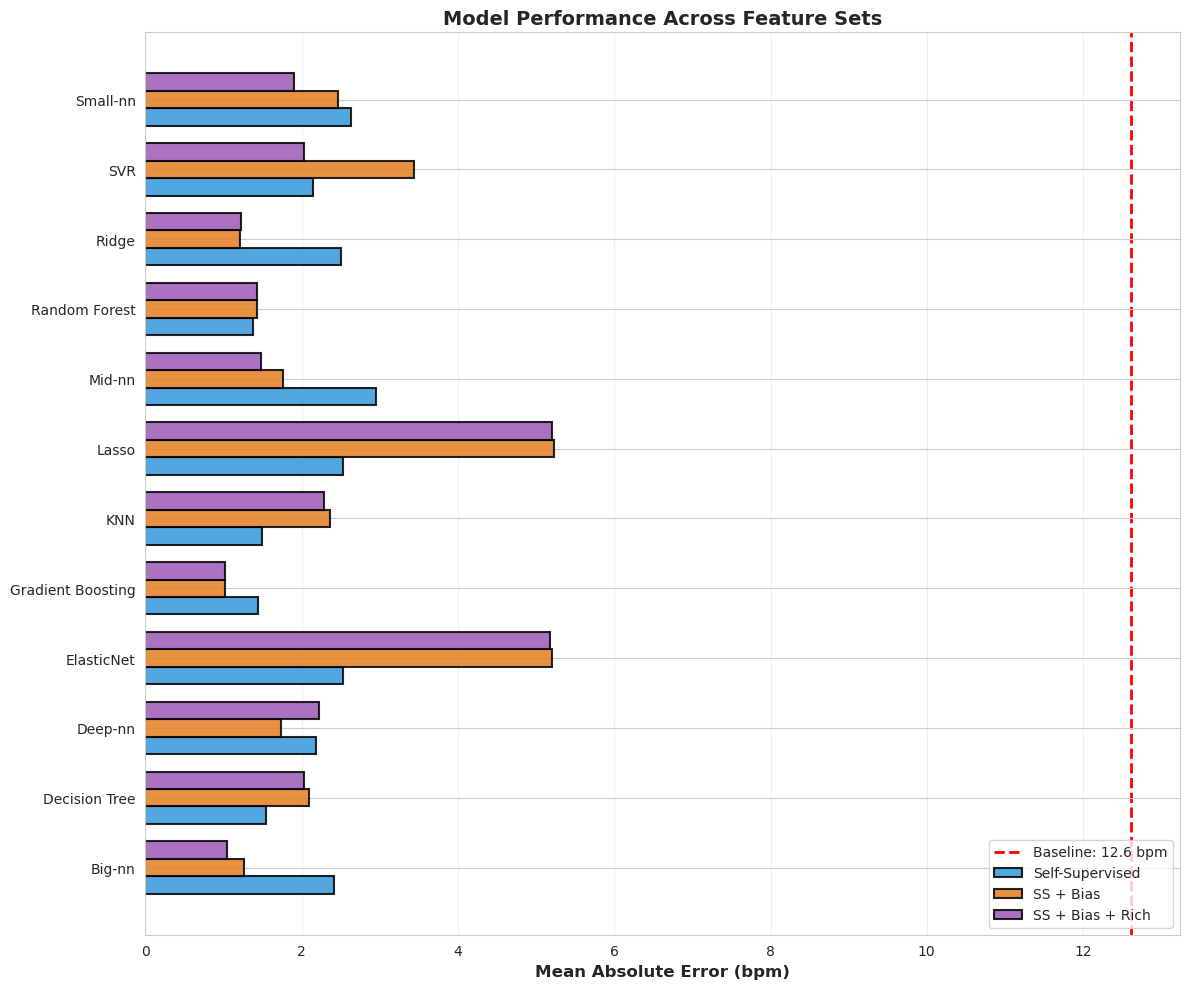

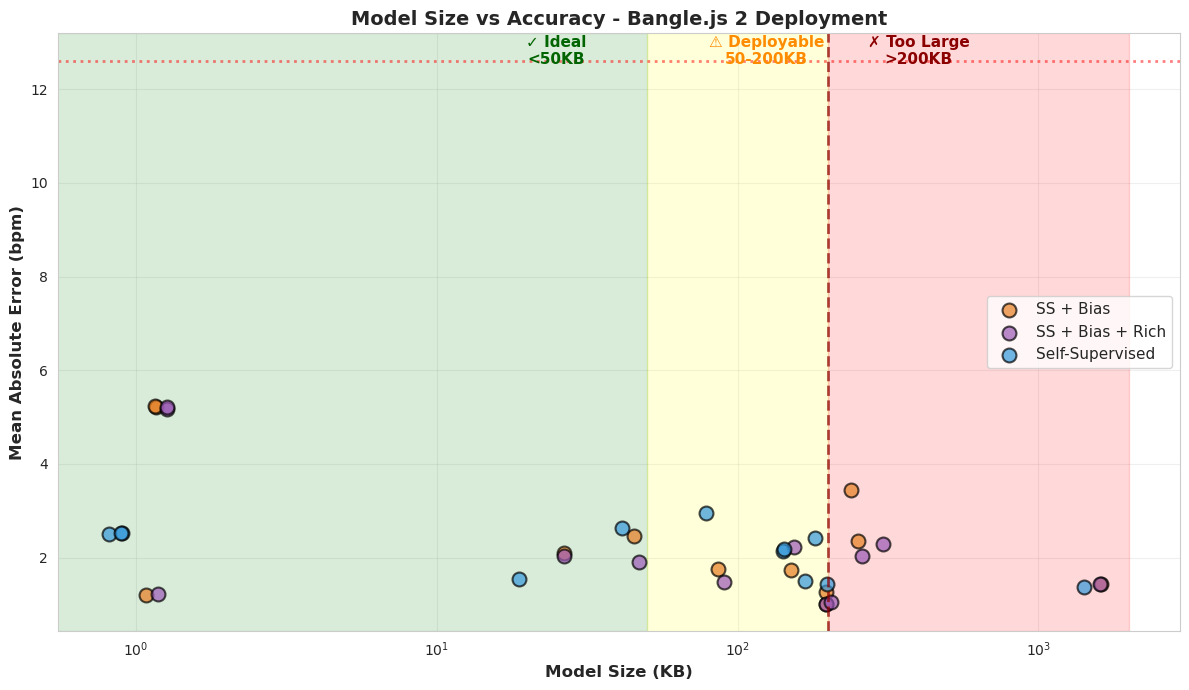

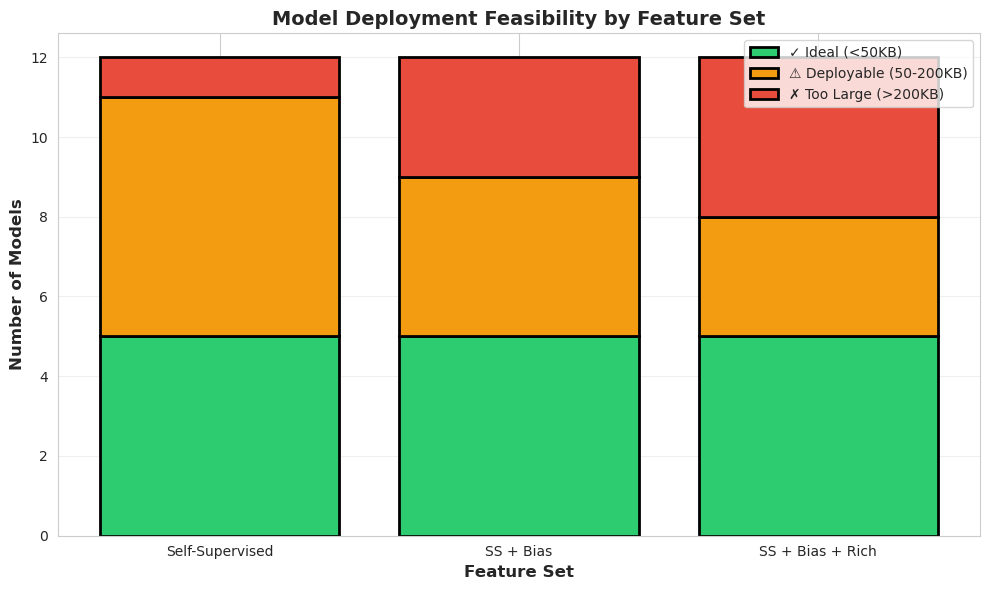


BANGLE.JS 2 DEPLOYMENT SUMMARY

Self-Supervised:
  ⚠ DEPLOYABLE: Gradient Boosting
  MAE: 1.44 bpm (Δ 11.17)
  Size: 198.2 KB (99% of RAM)

SS + Bias:
  ⚠ DEPLOYABLE: Gradient Boosting
  MAE: 1.01 bpm (Δ 11.60)
  Size: 196.8 KB (98% of RAM)

SS + Bias + Rich:
  ⚠ DEPLOYABLE: Gradient Boosting
  MAE: 1.02 bpm (Δ 11.59)
  Size: 196.4 KB (98% of RAM)



In [283]:
import matplotlib.pyplot as plt
import numpy as np

# Define feature set colors and markers
FEATURE_COLORS = {
    'self_supervised': '#3498db',
    'ss+bias': '#e67e22',
    'ss+bias+rich': '#9b59b6'
}

FEATURE_LABELS = {
    'self_supervised': 'Self-Supervised',
    'ss+bias': 'SS + Bias',
    'ss+bias+rich': 'SS + Bias + Rich'
}

baseline_mae = 12.61

# =============================================================================
# Plot 1: MAE by Model Type - Grouped by Model, Colored by Feature Set
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 10))

# Get unique models and feature sets
models = sorted(all_models['Model'].unique())
feature_sets = sorted(all_models['feature_set'].unique())

# Calculate positions
width = 0.25
x_pos = np.arange(len(models))

# Plot bars for each feature set
for i, fs in enumerate(feature_sets):
    subset = all_models[all_models['feature_set'] == fs].set_index('Model')
    
    # Get MAE values for each model (NaN if model doesn't exist for this feature set)
    mae_values = [subset.loc[model, 'MAE'] if model in subset.index else np.nan 
                  for model in models]
    
    # Plot bars
    offset = width * (i - 1)  # Center the bars
    bars = ax.barh([x + offset for x in x_pos], mae_values, width,
                   label=FEATURE_LABELS[fs],
                   color=FEATURE_COLORS[fs],
                   edgecolor='black', linewidth=1.5, alpha=0.85)

# Baseline line
ax.axvline(baseline_mae, color='red', linestyle='--', linewidth=2, 
           label=f'Baseline: {baseline_mae:.1f} bpm', zorder=0)

ax.set_yticks(x_pos)
ax.set_yticklabels(models)
ax.set_xlabel('Mean Absolute Error (bpm)', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Across Feature Sets', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='lower right')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# Plot 2: Size vs MAE - Clean View with Deployment Zones
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 7))

# Background zones
ax.axvspan(0, 50, alpha=0.15, color='green')
ax.axvspan(50, 200, alpha=0.15, color='yellow')
ax.axvspan(200, 2000, alpha=0.15, color='red')
ax.axvline(200, color='darkred', linestyle='--', linewidth=2, alpha=0.7)

# Plot each feature set
for fs in all_models['feature_set'].unique():
    subset = all_models[all_models['feature_set'] == fs]
    ax.scatter(subset['Size_Bytes']/1000, subset['MAE'], 
              s=100, c=FEATURE_COLORS[fs], alpha=0.7,
              edgecolors='black', linewidth=1.5,
              label=FEATURE_LABELS[fs])

# Add baseline line
ax.axhline(baseline_mae, color='red', linestyle=':', linewidth=2, alpha=0.5)

# Add zone labels
ax.text(25, ax.get_ylim()[1]*0.95, '✓ Ideal\n<50KB', 
        ha='center', fontsize=11, fontweight='bold', color='darkgreen')
ax.text(125, ax.get_ylim()[1]*0.95, '⚠ Deployable\n50-200KB', 
        ha='center', fontsize=11, fontweight='bold', color='darkorange')
ax.text(400, ax.get_ylim()[1]*0.95, '✗ Too Large\n>200KB', 
        ha='center', fontsize=11, fontweight='bold', color='darkred')

ax.set_xlabel('Model Size (KB)', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Absolute Error (bpm)', fontsize=12, fontweight='bold')
ax.set_title('Model Size vs Accuracy - Bangle.js 2 Deployment', 
             fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# Plot 3: Deployment Summary - Stacked Bar Chart
# =============================================================================
fig, ax = plt.subplots(figsize=(10, 6))

deployment_data = []
for fs in sorted(all_models['feature_set'].unique()):
    subset = all_models[all_models['feature_set'] == fs]
    
    ideal = subset[subset['Size_Bytes']/1000 < 50]
    deployable = subset[(subset['Size_Bytes']/1000 >= 50) & (subset['Size_Bytes']/1000 < 200)]
    too_large = subset[subset['Size_Bytes']/1000 >= 200]
    
    deployment_data.append({
        'Feature Set': FEATURE_LABELS[fs],
        'Ideal (<50KB)': len(ideal),
        'Deployable (50-200KB)': len(deployable),
        'Too Large (>200KB)': len(too_large)
    })

deploy_df = pd.DataFrame(deployment_data)
x = np.arange(len(deploy_df))

# Stacked bars
ax.bar(x, deploy_df['Ideal (<50KB)'], 
       label='✓ Ideal (<50KB)', color='#2ecc71', edgecolor='black', linewidth=2)
ax.bar(x, deploy_df['Deployable (50-200KB)'], 
       bottom=deploy_df['Ideal (<50KB)'],
       label='⚠ Deployable (50-200KB)', color='#f39c12', edgecolor='black', linewidth=2)
ax.bar(x, deploy_df['Too Large (>200KB)'], 
       bottom=deploy_df['Ideal (<50KB)'] + deploy_df['Deployable (50-200KB)'],
       label='✗ Too Large (>200KB)', color='#e74c3c', edgecolor='black', linewidth=2)

ax.set_xlabel('Feature Set', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Models', fontsize=12, fontweight='bold')
ax.set_title('Model Deployment Feasibility by Feature Set', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(deploy_df['Feature Set'])
ax.legend(fontsize=10, loc='upper right')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# Terminal Summary
# =============================================================================
print(f"\n{'='*70}")
print("BANGLE.JS 2 DEPLOYMENT SUMMARY")
print(f"{'='*70}")

for fs in sorted(all_models['feature_set'].unique()):
    subset = all_models[all_models['feature_set'] == fs]
    
    # Get best deployable (<200KB)
    deployable = subset[subset['Size_Bytes']/1000 < 200].sort_values('MAE')
    
    print(f"\n{FEATURE_LABELS[fs]}:")
    
    if len(deployable) > 0:
        best = deployable.iloc[0]
        size_kb = best['Size_Bytes']/1000
        
        if size_kb < 50:
            status = "✓ IDEAL"
        elif size_kb < 200:
            status = "⚠ DEPLOYABLE"
        else:
            status = "✗ TOO LARGE"
        
        print(f"  {status}: {best['Model']}")
        print(f"  MAE: {best['MAE']:.2f} bpm (Δ {baseline_mae - best['MAE']:.2f})")
        print(f"  Size: {size_kb:.1f} KB ({size_kb/200*100:.0f}% of RAM)")
    else:
        print(f"  ✗ No models fit in 200KB RAM")

print(f"\n{'='*70}")

In [284]:
#

Analyzing: Ridge (ss+bias)
Size: 1.1 KB
MAE: 1.21 bpm


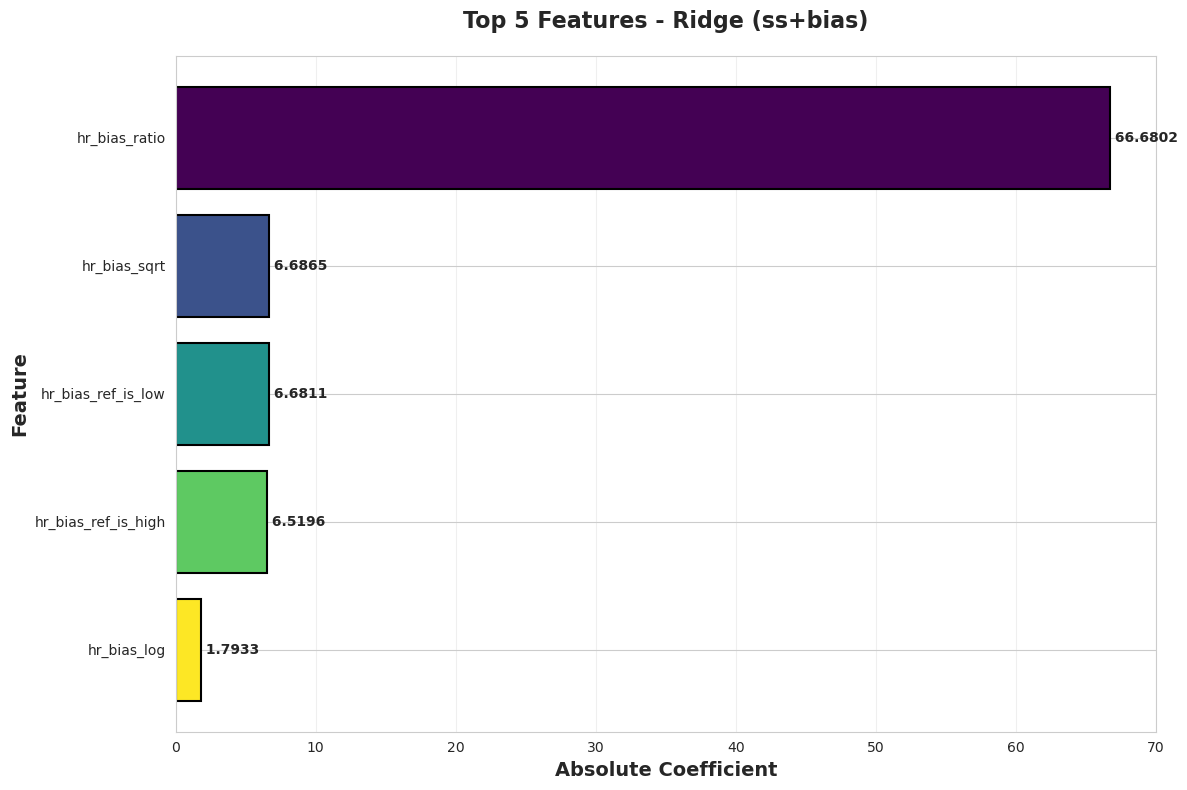

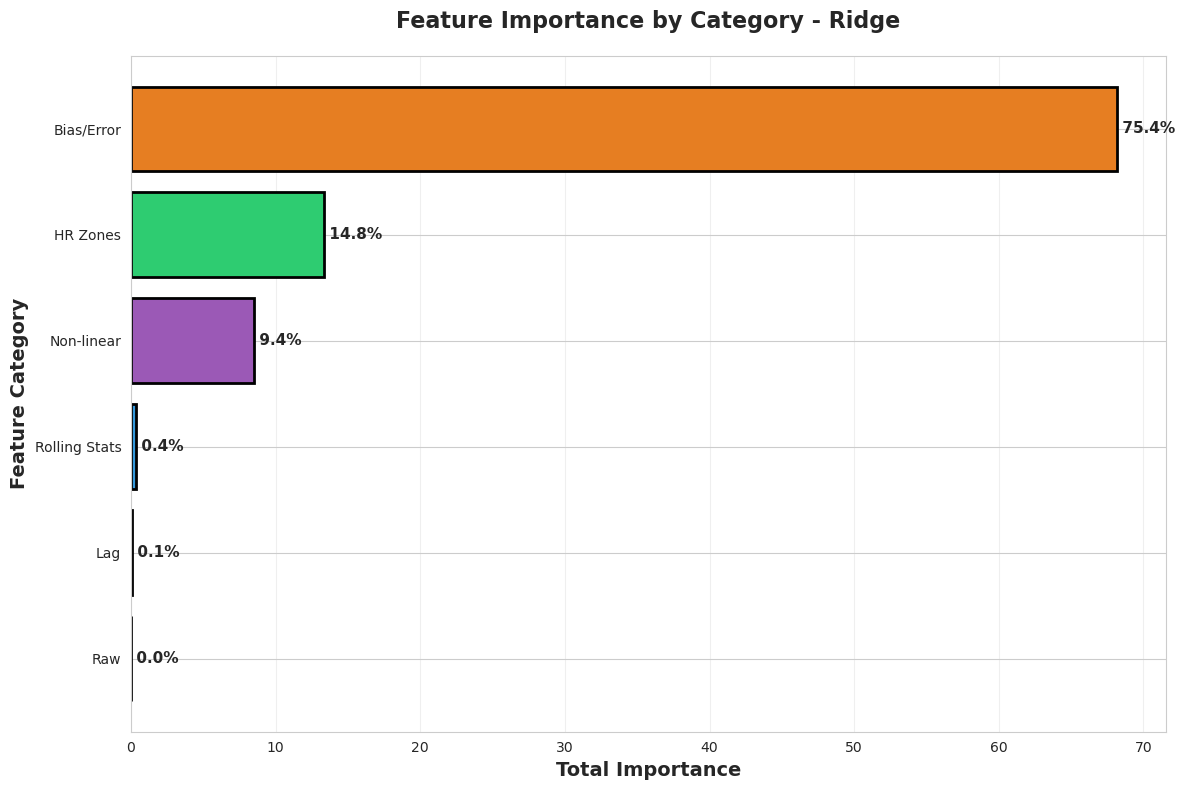


FEATURE IMPORTANCE SUMMARY - Ridge
Feature Set: ss+bias
Size: 1.1 KB
MAE: 1.21 bpm
R²: 0.9705

Top 10 Most Important Features:
 1. hr_bias_ratio                  66.6802 (Bias/Error)
 2. hr_bias_sqrt                   6.6865 (Non-linear)
 3. hr_bias_ref_is_low             6.6811 (HR Zones)
 4. hr_bias_ref_is_high            6.5196 (HR Zones)
 5. hr_bias_log                    1.7933 (Non-linear)
 6. hr_bias_times_low              0.4906 (Bias/Error)
 7. hr_bias_times_high             0.4329 (Bias/Error)
 8. hr_bias_times_med              0.4119 (Bias/Error)
 9. hr_bias_ref_is_med             0.1615 (HR Zones)
10. hr_rolling_std_30              0.1607 (Rolling Stats)

Importance by Category:
  Bias/Error            68.1589 ( 75.4%)
  HR Zones              13.3623 ( 14.8%)
  Non-linear             8.4798 (  9.4%)
  Rolling Stats          0.3218 (  0.4%)
  Lag                    0.0715 (  0.1%)
  Raw                    0.0002 (  0.0%)



In [ ]:
# Get best deployable model (under 100KB)
deployable = all_models[all_models['Size_KB'] < 100].sort_values('MAE')
best_row = deployable.iloc[0]
best_model_obj = best_row['model_obj']
best_name = best_row['Model']
best_fs = best_row['feature_set']

# Get appropriate feature set
if best_fs == "self_supervised":
    X = X_ss
elif best_fs == "ss+bias":
    X = X_bias
elif best_fs == "ss+bias+rich":
    X = X_rich

y = y_rich  # All ys are aligned
feature_names = X.columns

print(f"Analyzing: {best_name} ({best_fs})")
print(f"Size: {best_row['Size_KB']:.1f} KB")
print(f"MAE: {best_row['MAE']:.2f} bpm")

# Extract feature importance based on model type
if hasattr(best_model_obj, 'coef_'):
    # Linear models - use absolute coefficients
    importances = np.abs(best_model_obj.coef_)
    importance_type = 'Absolute Coefficient'
elif hasattr(best_model_obj, 'feature_importances_'):
    # Tree-based models
    importances = best_model_obj.feature_importances_
    importance_type = 'Feature Importance'
else:
    # Neural network - use permutation importance
    print("⚠️ Neural network detected - using permutation importance (this may take a moment)...")
    
    # For NNs, need to scale the data if scaler is available
    X_for_importance = X
    if 'Scaler' in best_row.index and best_row['Scaler'] is not None:
        X_for_importance = best_row['Scaler'].transform(X)
    
    result = permutation_importance(best_model_obj, X_for_importance, y, 
                                   n_repeats=10, random_state=42, n_jobs=-1)
    importances = result.importances_mean
    importance_type = 'Permutation Importance'

# Create importance dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# =============================================================================
# Plot 1: Top Features Bar Chart
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 8))

top_n = min(5, len(importance_df))
top_features = importance_df.head(top_n)

colors = plt.cm.viridis(np.linspace(0, 1, top_n))

bars = ax.barh(range(top_n), top_features['Importance'], 
              color=colors, edgecolor='black', linewidth=1.5)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel(importance_type, fontsize=14, fontweight='bold')
ax.set_ylabel('Feature', fontsize=14, fontweight='bold')
ax.set_title(f'Top {top_n} Features - {best_name} ({best_fs})', 
            fontsize=16, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add values on bars
for i, (idx, row) in enumerate(top_features.iterrows()):
    ax.text(row['Importance'], i, f' {row["Importance"]:.4f}', 
           va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# =============================================================================
# Plot 2: Feature Importance by Category
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 8))

# Categorize features
categories = []
for feat in importance_df['Feature']:
    feat_lower = feat.lower()
    if 'lag' in feat_lower:
        categories.append('Lag')
    elif 'rolling' in feat_lower or 'mean' in feat_lower or 'std' in feat_lower:
        categories.append('Rolling Stats')
    elif 'squared' in feat_lower or 'sqrt' in feat_lower or 'log' in feat_lower:
        categories.append('Non-linear')
    elif 'is_' in feat_lower or 'zone' in feat_lower or 'hr_times' in feat_lower:
        categories.append('HR Zones')
    elif 'hour' in feat_lower or 'daytime' in feat_lower or 'night' in feat_lower:
        categories.append('Time')
    elif 'bias' in feat_lower or 'error' in feat_lower:
        categories.append('Bias/Error')
    else:
        categories.append('Raw')

importance_df['Category'] = categories

# Aggregate by category
category_importance = importance_df.groupby('Category')['Importance'].sum().sort_values(ascending=False)

colors_cat = {
    'Lag': '#e74c3c',
    'Rolling Stats': '#3498db',
    'Non-linear': '#9b59b6',
    'HR Zones': '#2ecc71',
    'Time': '#f39c12',
    'Bias/Error': '#e67e22',
    'Raw': '#34495e'
}

bar_colors = [colors_cat.get(cat, '#95a5a6') for cat in category_importance.index]

ax.barh(range(len(category_importance)), category_importance.values, 
       color=bar_colors, edgecolor='black', linewidth=2)
ax.set_yticks(range(len(category_importance)))
ax.set_yticklabels(category_importance.index)
ax.set_xlabel('Total Importance', fontsize=14, fontweight='bold')
ax.set_ylabel('Feature Category', fontsize=14, fontweight='bold')
ax.set_title(f'Feature Importance by Category - {best_name}', 
            fontsize=16, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add percentage labels
total_importance = category_importance.sum()
for i, (cat, imp) in enumerate(category_importance.items()):
    pct = (imp / total_importance) * 100
    ax.text(imp, i, f' {pct:.1f}%', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# =============================================================================
# Print Summary
# =============================================================================
print(f"\n{'='*70}")
print(f"FEATURE IMPORTANCE SUMMARY - {best_name}")
print(f"{'='*70}")
print(f"Feature Set: {best_fs}")
print(f"Size: {best_row['Size_KB']:.1f} KB")
print(f"MAE: {best_row['MAE']:.2f} bpm")
print(f"R²: {best_row['R²']:.4f}")

print(f"\nTop 10 Most Important Features:")
for i, (idx, row) in enumerate(importance_df.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:30s} {row['Importance']:.4f} ({row['Category']})")

print(f"\nImportance by Category:")
for cat, imp in category_importance.items():
    pct = (imp / total_importance) * 100
    print(f"  {cat:20s} {imp:8.4f} ({pct:5.1f}%)")

print(f"\n{'='*70}")

RELIABILITY DETECTION BREAKDOWN

SELF_SUPERVISED:
  Total samples: 1696
  Flagged as unreliable: 0 (0.0%)
  Breakdown:
    Sudden change (>30 bpm): 0
    Too low (<40 bpm): 0
    Too high (>200 bpm): 0
    High variance (std>15): 0

SS+BIAS:
  Total samples: 1696
  Flagged as unreliable: 0 (0.0%)
  Breakdown:
    Sudden change (>30 bpm): 0
    Too low (<40 bpm): 0
    Too high (>200 bpm): 0
    High variance (std>15): 0

SS+BIAS+RICH:
  Total samples: 1696
  Flagged as unreliable: 0 (0.0%)
  Breakdown:
    Sudden change (>30 bpm): 0
    Too low (<40 bpm): 0
    Too high (>200 bpm): 0
    High variance (std>15): 0


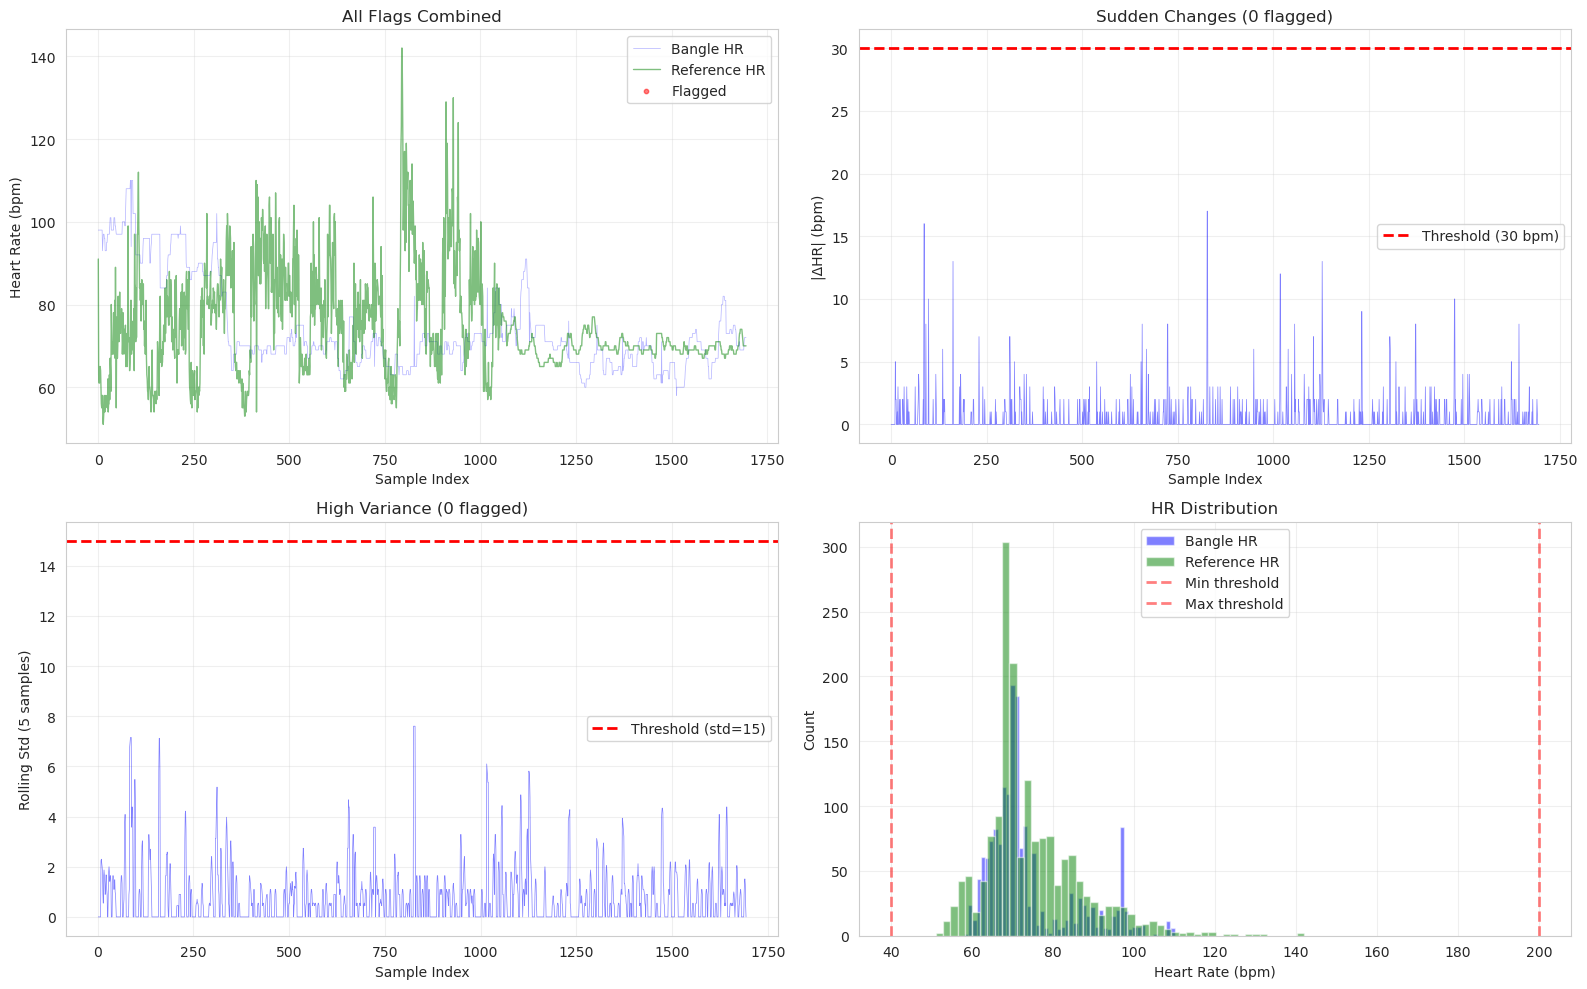


SUGGESTED THRESHOLD ADJUSTMENTS

Current thresholds are too strict. Consider:
  Sudden change: currently 30 bpm
    - 95th percentile of changes: 3.0 bpm
    - 99th percentile of changes: 8.0 bpm
    - Suggested: 40-50 bpm

  Rolling variance: currently std > 15
    - 95th percentile of std: 3.3
    - 99th percentile of std: 5.8
    - Suggested: std > 20-25

  HR range: currently 40-200 bpm
    - Min HR observed: 58 bpm
    - Max HR observed: 110 bpm
    - Suggested: 35-180 bpm (for exercise data)

With relaxed thresholds:
  Flagged: 0 (0.0%)
  Reduction: 0 fewer flags



In [ ]:
# =============================================================================
# Analyze What's Being Flagged and Why
# =============================================================================

def analyze_unreliable_reasons(hr, window=5):
    """Break down why readings are flagged as unreliable"""
    hr_series = pd.Series(hr).reset_index(drop=True)
    
    reasons = pd.DataFrame({
        'sudden_drop': hr_series.diff().abs() > 30,
        'too_low': hr_series < 40,
        'too_high': hr_series > 200,
    })
    
    # High variance in window
    if len(hr_series) > window:
        rolling_std = hr_series.rolling(window, center=True).std()
        reasons['high_variance'] = rolling_std > 15
    else:
        reasons['high_variance'] = False
    
    reasons['any_flag'] = reasons.any(axis=1)
    
    return reasons

# Analyze each feature set
feature_sets = {
    'self_supervised': X_ss,
    'ss+bias': X_bias,
    'ss+bias+rich': X_rich
}

print(f"{'='*70}")
print("RELIABILITY DETECTION BREAKDOWN")
print(f"{'='*70}")

for fs_name, X in feature_sets.items():
    X_aligned, y_aligned = X.align(y_rich, join='inner', axis=0)
    bangle_hr = X_aligned.iloc[:, 0].values
    
    reasons = analyze_unreliable_reasons(bangle_hr)
    
    print(f"\n{fs_name.upper()}:")
    print(f"  Total samples: {len(bangle_hr)}")
    print(f"  Flagged as unreliable: {reasons['any_flag'].sum()} ({reasons['any_flag'].sum()/len(bangle_hr)*100:.1f}%)")
    print(f"  Breakdown:")
    print(f"    Sudden change (>30 bpm): {reasons['sudden_drop'].sum()}")
    print(f"    Too low (<40 bpm): {reasons['too_low'].sum()}")
    print(f"    Too high (>200 bpm): {reasons['too_high'].sum()}")
    print(f"    High variance (std>15): {reasons['high_variance'].sum()}")

# =============================================================================
# Visualize the Problem
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

fs_name = 'self_supervised'
X_aligned, y_aligned = X_ss.align(y_rich, join='inner', axis=0)
bangle_hr = X_aligned.iloc[:, 0].values
reasons = analyze_unreliable_reasons(bangle_hr)

# Plot 1: HR time series with flags
ax = axes[0, 0]
time_idx = np.arange(len(bangle_hr))
ax.plot(time_idx, bangle_hr, 'b-', alpha=0.3, linewidth=0.5, label='Bangle HR')
ax.plot(time_idx, y_aligned.values, 'g-', alpha=0.5, linewidth=1, label='Reference HR')
ax.scatter(time_idx[reasons['any_flag']], bangle_hr[reasons['any_flag']], 
          c='red', s=10, alpha=0.5, label='Flagged')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Heart Rate (bpm)')
ax.set_title('All Flags Combined')
ax.legend()
ax.grid(alpha=0.3)

# Plot 2: Sudden changes
ax = axes[0, 1]
hr_diff = np.abs(np.diff(bangle_hr, prepend=bangle_hr[0]))
ax.plot(time_idx, hr_diff, 'b-', alpha=0.5, linewidth=0.5)
ax.axhline(30, color='red', linestyle='--', linewidth=2, label='Threshold (30 bpm)')
ax.fill_between(time_idx, 0, hr_diff, where=hr_diff>30, alpha=0.3, color='red')
ax.set_xlabel('Sample Index')
ax.set_ylabel('|ΔHR| (bpm)')
ax.set_title(f'Sudden Changes ({reasons["sudden_drop"].sum()} flagged)')
ax.legend()
ax.grid(alpha=0.3)

# Plot 3: Rolling variance
ax = axes[1, 0]
rolling_std = pd.Series(bangle_hr).rolling(5, center=True).std()
ax.plot(time_idx, rolling_std, 'b-', alpha=0.5, linewidth=0.5)
ax.axhline(15, color='red', linestyle='--', linewidth=2, label='Threshold (std=15)')
ax.fill_between(time_idx, 0, rolling_std, where=rolling_std>15, alpha=0.3, color='red')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Rolling Std (5 samples)')
ax.set_title(f'High Variance ({reasons["high_variance"].sum()} flagged)')
ax.legend()
ax.grid(alpha=0.3)

# Plot 4: Distribution comparison
ax = axes[1, 1]
ax.hist(bangle_hr, bins=50, alpha=0.5, label='Bangle HR', color='blue')
ax.hist(y_aligned.values, bins=50, alpha=0.5, label='Reference HR', color='green')
ax.axvline(40, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Min threshold')
ax.axvline(200, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Max threshold')
ax.set_xlabel('Heart Rate (bpm)')
ax.set_ylabel('Count')
ax.set_title('HR Distribution')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# Suggest Better Thresholds
# =============================================================================
print(f"\n{'='*70}")
print("SUGGESTED THRESHOLD ADJUSTMENTS")
print(f"{'='*70}")

X_aligned, y_aligned = X_ss.align(y_rich, join='inner', axis=0)
bangle_hr = X_aligned.iloc[:, 0].values

# Calculate statistics
hr_diff_abs = np.abs(np.diff(bangle_hr, prepend=bangle_hr[0]))
rolling_std = pd.Series(bangle_hr).rolling(5, center=True).std().dropna()

print(f"\nCurrent thresholds are too strict. Consider:")
print(f"  Sudden change: currently 30 bpm")
print(f"    - 95th percentile of changes: {np.percentile(hr_diff_abs, 95):.1f} bpm")
print(f"    - 99th percentile of changes: {np.percentile(hr_diff_abs, 99):.1f} bpm")
print(f"    - Suggested: 40-50 bpm")

print(f"\n  Rolling variance: currently std > 15")
print(f"    - 95th percentile of std: {np.percentile(rolling_std, 95):.1f}")
print(f"    - 99th percentile of std: {np.percentile(rolling_std, 99):.1f}")
print(f"    - Suggested: std > 20-25")

print(f"\n  HR range: currently 40-200 bpm")
print(f"    - Min HR observed: {bangle_hr.min():.0f} bpm")
print(f"    - Max HR observed: {bangle_hr.max():.0f} bpm")
print(f"    - Suggested: 35-180 bpm (for exercise data)")

# Test relaxed thresholds
def detect_unreliable_relaxed(hr, window=5):
    """More relaxed unreliability detection"""
    hr_series = pd.Series(hr).reset_index(drop=True)
    flags = pd.Series(False, index=hr_series.index)
    
    # Relaxed thresholds
    sudden_drop = hr_series.diff().abs() > 50  # Was 30
    too_low = hr_series < 35  # Was 40
    too_high = hr_series > 180  # Was 200
    
    if len(hr_series) > window:
        rolling_std = hr_series.rolling(window, center=True).std()
        high_variance = rolling_std > 25  # Was 15
    else:
        high_variance = pd.Series(False, index=hr_series.index)
    
    flags = sudden_drop | too_low | too_high | high_variance
    return flags

relaxed_flags = detect_unreliable_relaxed(bangle_hr)
print(f"\nWith relaxed thresholds:")
print(f"  Flagged: {relaxed_flags.sum()} ({relaxed_flags.sum()/len(bangle_hr)*100:.1f}%)")
print(f"  Reduction: {reasons['any_flag'].sum() - relaxed_flags.sum()} fewer flags")

print(f"\n{'='*70}")

In [ ]:
def export_hr_model_with_reliability(model_row, X_train, y_train, mae):
    """
    Export model + reliability detector to Bangle.js
    
    Parameters:
    -----------
    model_row : pd.Series
        Row from all_models DataFrame containing model info
    X_train : pd.DataFrame
        Training features (for feature names)
    y_train : pd.Series
        Training labels
    mae : float
        Model's MAE score
    """
    
    model_obj = model_row['model_obj']
    
    # Model parameters
    model_data = {
        "metadata": {
            "model_name": model_row['Model'],
            "feature_set": model_row['feature_set'],
            "mae_bpm": float(mae),
            "r2": float(model_row['R²']),
            "size_kb": float(model_row['Size_KB']),
            "model_type": f"{model_row['Model']} (reliable samples only)",
            "n_features": len(X_train.columns),
            "created": pd.Timestamp.now().isoformat(),
            "note": "Only accurate for rest/light activity (HR < 110)"
        },
        "coefficients": model_obj.coef_.tolist() if hasattr(model_obj, 'coef_') else None,
        "intercept": float(model_obj.intercept_) if hasattr(model_obj, 'intercept_') else None,
        "feature_names": X_train.columns.tolist(),
        "reliability_thresholds": {
            "sudden_change": 30,
            "min_hr": 40,
            "max_hr": 200,
            "high_variance_std": 15,
            "exercise_threshold": 110
        }
    }
    
    # Save model JSON
    with open('models/bangle_hr_model_with_reliability.json', 'w') as f:
        json.dump(model_data, f, indent=2)
    
    # Create Bangle.js app code
    js_code = f"""// HR Model with Reliability Detection
// Model: {model_row['Model']} ({model_row['feature_set']})
// MAE: {mae:.1f} bpm | Size: {model_row['Size_KB']:.1f} KB
// Note: Only accurate for rest/light activity

const modelData = require('bangle_hr_model_with_reliability.json');

class HRCorrector {{
  constructor() {{
    this.hrBuffer = [];
    this.bufferSize = 10;
  }}
  
  addReading(hr) {{
    this.hrBuffer.push(hr);
    if (this.hrBuffer.length > this.bufferSize) {{
      this.hrBuffer.shift();
    }}
  }}
  
  isReliable(hr) {{
    const thresh = modelData.reliability_thresholds;
    
    // Too low/high
    if (hr < thresh.min_hr || hr > thresh.max_hr) return false;
    
    // Sudden change
    if (this.hrBuffer.length >= 2) {{
      const prev = this.hrBuffer[this.hrBuffer.length - 1];
      if (Math.abs(hr - prev) > thresh.sudden_change) return false;
    }}
    
    // High variance (motion artifact)
    if (this.hrBuffer.length >= 5) {{
      const mean = this.hrBuffer.reduce((a, b) => a + b) / this.hrBuffer.length;
      const variance = this.hrBuffer.reduce((sum, val) => sum + Math.pow(val - mean, 2), 0) / this.hrBuffer.length;
      const std = Math.sqrt(variance);
      if (std > thresh.high_variance_std) return false;
    }}
    
    return true;
  }}
  
  createFeatures(hr) {{
    const hour = new Date().getHours();
    const features = {{}};
    
    // Add features based on what's in the model
    modelData.feature_names.forEach(name => {{
      if (name === 'HEART_RATE') {{
        features[name] = hr;
      }} else if (name === 'HEART_RATE_squared') {{
        features[name] = hr * hr;
      }} else if (name === 'HEART_RATE_sqrt') {{
        features[name] = Math.sqrt(hr);
      }} else if (name.startsWith('is_')) {{
        // HR zone features
        if (name === 'is_very_low') features[name] = hr < 60 ? 1 : 0;
        else if (name === 'is_low') features[name] = (hr >= 60 && hr < 80) ? 1 : 0;
        else if (name === 'is_med') features[name] = (hr >= 80 && hr < 100) ? 1 : 0;
        else if (name === 'is_high') features[name] = (hr >= 100 && hr < 120) ? 1 : 0;
        else if (name === 'is_very_high') features[name] = hr >= 120 ? 1 : 0;
        else if (name === 'is_daytime') features[name] = (hour >= 6 && hour < 22) ? 1 : 0;
        else if (name === 'is_night') features[name] = hour < 6 ? 1 : 0;
        else features[name] = 0;
      }} else if (name === 'hour') {{
        features[name] = hour;
      }} else if (name.includes('lag')) {{
        // For lag features, use current HR as approximation
        features[name] = hr;
      }} else {{
        // Default to 0 for unknown features
        features[name] = 0;
      }}
    }});
    
    return features;
  }}
  
  predict(features) {{
    if (!modelData.coefficients || !modelData.intercept) {{
      // Non-linear model - can't export directly
      console.log("⚠ Model type not supported for export");
      return features.HEART_RATE || 60;
    }}
    
    let sum = modelData.intercept;
    
    modelData.feature_names.forEach((name, i) => {{
      sum += (features[name] || 0) * modelData.coefficients[i];
    }});
    
    return Math.round(Math.max(45, Math.min(200, sum)));
  }}
  
  getCorrectedHR(rawHR) {{
    this.addReading(rawHR);
    
    const reliable = this.isReliable(rawHR);
    const features = this.createFeatures(rawHR);
    const corrected = this.predict(features);
    
    return {{
      raw: rawHR,
      corrected: reliable ? corrected : rawHR,
      reliable: reliable,
      confidence: reliable ? 100 : 0
    }};
  }}
}}

// App UI
const hrCorrector = new HRCorrector();
let lastHR = null;

function drawUI() {{
  g.clear();
  
  if (!lastHR) {{
    g.setFont("6x8", 2);
    g.drawString("Waiting for HR...", 10, 100);
    g.flip();
    return;
  }}
  
  const {{ raw, corrected, reliable }} = lastHR;
  
  g.setFont("6x8", 3);
  
  // Main HR display
  if (reliable) {{
    g.setColor("#0f0");  // Green
    g.drawString("HR: " + corrected, 10, 30);
  }} else {{
    g.setColor("#f80");  // Orange
    g.drawString("HR: " + raw, 10, 30);
  }}
  
  // Reliability indicator
  g.setFont("6x8", 2);
  if (reliable) {{
    g.setColor("#0f0");
    g.drawString("✓ Reliable", 10, 80);
  }} else {{
    g.setColor("#f80");
    g.drawString("⚠ Unreliable", 10, 80);
    g.setFont("6x8", 1.5);
    g.setColor("#888");
    g.drawString("(motion/exercise)", 10, 110);
  }}
  
  // Raw reading (small, bottom)
  g.setFont("6x8", 1.5);
  g.setColor("#888");
  g.drawString("Raw: " + raw, 10, 150);
  
  g.flip();
}}

Bangle.on('HRM', (hrm) => {{
  if (hrm.bpm > 0) {{
    lastHR = hrCorrector.getCorrectedHR(hrm.bpm);
    drawUI();
  }}
}});

Bangle.setHRMPower(1);
drawUI();
"""
    
    with open('models/bangle_hr_app_with_reliability.js', 'w') as f:
        f.write(js_code)
    
    print("✓ Exported model and app:")
    print(f"  Model: {model_row['Model']} ({model_row['feature_set']})")
    print(f"  MAE: {mae:.2f} bpm | R²: {model_row['R²']:.4f} | Size: {model_row['Size_KB']:.1f} KB")
    print("\nFiles created:")
    print("  - models/bangle_hr_model_with_reliability.json")
    print("  - models/bangle_hr_app_with_reliability.js")
    print(f"\nBehavior:")
    print(f"  - Shows corrected HR (green ✓) when reliable")
    print(f"  - Shows raw HR (orange ⚠) during exercise/motion")
    print(f"  - Features: {len(X_train.columns)} ({', '.join(X_train.columns[:3])}...)")

# =============================================================================
# Usage Example
# =============================================================================

# Get best deployable model
deployable = all_models[all_models['Size_KB'] < 100].sort_values('MAE')
best_model_row = deployable.iloc[0]

# Get the appropriate feature set
if best_model_row['feature_set'] == "self_supervised":
    X_export = X_ss
elif best_model_row['feature_set'] == "ss+bias":
    X_export = X_bias
elif best_model_row['feature_set'] == "ss+bias+rich":
    X_export = X_rich

# Train on reliable samples only (optional - or use the existing model)
# For simplicity, we'll export the existing model
# You can add reliability filtering here if desired

# Export
export_hr_model_with_reliability(
    model_row=best_model_row,
    X_train=X_export,
    y_train=y_rich,
    mae=best_model_row['MAE']
)

✓ Exported model and app:
  Model: Ridge (ss+bias)
  MAE: 1.21 bpm | R²: 0.9705 | Size: 1.1 KB

Files created:
  - models/bangle_hr_model_with_reliability.json
  - models/bangle_hr_app_with_reliability.js

Behavior:
  - Shows corrected HR (green ✓) when reliable
  - Shows raw HR (orange ⚠) during exercise/motion
  - Features: 22 (hr_lag_1, hr_lag_2, hr_lag_5...)


In [ ]:
# Check if exercise samples are underrepresented
print("HR distribution in training data:")
print(y_rich.describe())

print(f"\nSamples by zone:")
zone_counts = pd.cut(y_rich, 
                     bins=[0, 70, 100, 130, 200], 
                     labels=['Rest', 'Light', 'Moderate', 'Intense']).value_counts()
print(zone_counts)

# =============================================================================
# Detect Unreliable Readings
# =============================================================================
def detect_unreliable_readings(hr, window=5):
    """Flag readings that are likely motion artifacts"""
    hr_series = pd.Series(hr).reset_index(drop=True)
    flags = pd.Series(False, index=hr_series.index)
    
    # Sudden drops >30 bpm
    sudden_drop = hr_series.diff().abs() > 30
    
    # Unrealistic values
    too_low = hr_series < 40
    too_high = hr_series > 200
    
    # High variance in window (thrashing)
    if len(hr_series) > window:
        rolling_std = hr_series.rolling(window, center=True).std()
        high_variance = rolling_std > 15
    else:
        high_variance = pd.Series(False, index=hr_series.index)
    
    flags = sudden_drop | too_low | too_high | high_variance
    
    return flags

# =============================================================================
# Analyze Reliability for Each Feature Set
# =============================================================================
print(f"\n{'='*70}")
print("RELIABILITY ANALYSIS")
print(f"{'='*70}")

feature_sets = {
    'self_supervised': X_ss,
    'ss+bias': X_bias,
    'ss+bias+rich': X_rich
}

for fs_name, X in feature_sets.items():
    print(f"\n{fs_name.upper()}:")
    
    # Detect unreliable readings from Bangle HR (first column assumed to be HEART_RATE)
    bangle_hr = X.iloc[:, 0].values
    unreliable = detect_unreliable_readings(bangle_hr)
    
    n_unreliable = unreliable.sum()
    n_total = len(unreliable)
    pct_unreliable = (n_unreliable / n_total) * 100
    
    print(f"  {n_unreliable} / {n_total} ({pct_unreliable:.1f}%) flagged as unreliable")
    
    # Train only on reliable samples
    reliable_mask = ~unreliable.values
    X_reliable = X[reliable_mask]
    y_reliable = y_rich[reliable_mask]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_reliable, y_reliable, test_size=0.2, random_state=42
    )
    
    print(f"  Training on {len(X_train)} reliable samples...")
    
    # Train model on reliable data only
    model_reliable = Ridge(alpha=1.0)
    model_reliable.fit(X_train, y_train)
    
    # Test on reliable test data
    y_pred_reliable = model_reliable.predict(X_test)
    mae_reliable = mean_absolute_error(y_test, y_pred_reliable)
    
    print(f"  MAE with reliable-only training: {mae_reliable:.2f} bpm")
    
    # Compare to training on all data
    X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
        X, y_rich, test_size=0.2, random_state=42
    )
    
    model_all = Ridge(alpha=1.0)
    model_all.fit(X_train_all, y_train_all)
    y_pred_all = model_all.predict(X_test_all)
    mae_all = mean_absolute_error(y_test_all, y_pred_all)
    
    improvement = mae_all - mae_reliable
    print(f"  MAE with all data training: {mae_all:.2f} bpm")
    print(f"  Improvement from filtering: {improvement:+.2f} bpm")

# =============================================================================
# Visualize Unreliable Readings
# =============================================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for idx, (fs_name, X) in enumerate(feature_sets.items()):
    ax = axes[idx]
    
    bangle_hr = X.iloc[:, 0].values
    unreliable = detect_unreliable_readings(bangle_hr)
    
    # Plot all readings
    time_index = np.arange(len(bangle_hr))
    ax.scatter(time_index[~unreliable.values], bangle_hr[~unreliable.values], 
              s=10, alpha=0.5, color='green', label='Reliable')
    ax.scatter(time_index[unreliable.values], bangle_hr[unreliable.values], 
              s=20, alpha=0.8, color='red', marker='x', label='Unreliable')
    
    # Plot reference HR for comparison
    ax.plot(time_index, y_rich.values, color='blue', alpha=0.3, 
           linewidth=1, label='Reference HR')
    
    ax.set_ylabel('Heart Rate (bpm)', fontsize=11, fontweight='bold')
    ax.set_title(f'{fs_name} - Reliability Detection', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(alpha=0.3)
    ax.set_ylim([40, 200])

axes[-1].set_xlabel('Sample Index', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n{'='*70}")

HR distribution in training data:
count    2959.000000
mean       73.267996
std        10.588059
min        51.000000
25%        68.000000
50%        70.000000
75%        76.500000
max       149.000000
Name: HRREF, dtype: float64

Samples by zone:
HRREF
Rest        1574
Light       1298
Moderate      82
Intense        5
Name: count, dtype: int64

RELIABILITY ANALYSIS

SELF_SUPERVISED:
  0 / 1696 (0.0%) flagged as unreliable


IndexError: Boolean index has wrong length: 1696 instead of 2959

In [ ]:
# Analyze if Bangle confidence correlates with error
if 'HRM_CONFIDENCE' in aligned_data.columns:
    conf_col = 'HRM_CONFIDENCE'
    
    error_with_conf = pd.DataFrame({
        'error': (aligned_data['HEART_RATE'] - aligned_data['HRREF']).abs(),
        'confidence': aligned_data[conf_col]
    })
    
    print("\nError by confidence level:")
    print(error_with_conf.groupby(pd.cut(error_with_conf['confidence'], bins=5))['error'].agg(['mean', 'count']))
    
    # Train confidence-weighted model
    weights = aligned_data[conf_col] / 100.0  # Normalize to 0-1
    weights.fillna(1, inplace=True) # where there is no confidence value, assume 100%
    
    conf_weighted_model = Ridge(alpha=1.0)
    conf_weighted_model.fit(X_enriched, aligned_data['HRREF'], sample_weight=weights)
    
    print("\nConfidence-weighted model trained")
    
else:
    print("\n⚠️  No confidence data found in aligned samples")
    print("You need to log Bangle confidence values during data collection")
    print("\nHypothetical approach if you HAD confidence data:")

# Create simple adaptive weight function
def adaptive_correction(raw_hr, model_prediction, confidence):
    """
    Blend raw and corrected based on sensor confidence
    
    High confidence -> trust raw more
    Low confidence -> trust model more
    """
    trust_raw = confidence / 100.0
    trust_model = 1.0 - trust_raw
    
    blended = (raw_hr * trust_raw) + (model_prediction * trust_model)
    
    return round(blended)

# Testing
print("\nExample corrections:")
print("Raw | Model | Confidence | Weigted Reading")
print("-------------------------------------------")
for i in [90,50,10]:
    print(f"100 |   95  |    {i}      | {adaptive_correction(100, 95, i)}")

## DEPLOYMENT GUIDE

This model learns YOUR personal heart rate dynamics from reference data.
It predicts what your HR should be based on recent HR history.

HOW IT WORKS:
1. Collects last N heart rate readings from Bangle.js
2. Computes rolling statistics and rate of change
3. Predicts current HR using learned dynamics
4. Can smooth noisy Bangle.js readings

DEPLOYMENT OPTIONS:

A) REAL-TIME ON BANGLE.JS:
   - Keep buffer of a number of HR readings
   - Compute features (rolling means, changes, etc.)
   - Apply model to predict/smooth current HR
   - Lightweight models are always picked here to work on embedded systems

B) POST-PROCESSING:
   - Collect raw Bangle.js data
   - Apply model offline to clean/correct readings
   - Use for historical data analysis

C) HYBRID APPROACH:
   - Use dynamics model for smoothing
   - Periodically sync with reference device to recalibrate

This model knows how YOUR HR naturally changes. If Bangle.js gives a noisy/wrong reading, the model can detect
it doesn't follow your typical patterns and correct it.
